In [261]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from catboost import CatBoostRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.linear_model import Lasso
import matplotlib.ticker as ticker

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

from config.db_configs import *

In [262]:
import psycopg2

connection = psycopg2.connect(
            dbname=DB_CONFIG["dbname"],
            user=DB_CONFIG["user"],
            password=DB_CONFIG["password"],
            host=DB_CONFIG["host"],
            port=DB_CONFIG["port"])

In [263]:
query = "SELECT * FROM properties WHERE date = '2025-03-18'";
df_og = pd.read_sql(query, con = connection)
urls = df_og[['property_id','url']]
#df_og.drop('url', inplace=True, axis=1)

In [264]:
df_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4927 entries, 0 to 4926
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   db_id              4927 non-null   int64  
 1   property_id        4927 non-null   int64  
 2   price              4435 non-null   float64
 3   square             4927 non-null   float64
 4   price_per_sqm      4435 non-null   float64
 5   rooms              4927 non-null   int64  
 6   date               4927 non-null   object 
 7   url                4927 non-null   object 
 8   street             3061 non-null   object 
 9   district_1         4927 non-null   object 
 10  district_2         4927 non-null   object 
 11  city               4927 non-null   object 
 12  state              4927 non-null   object 
 13  heating            3690 non-null   object 
 14  floor              4866 non-null   object 
 15  rent               2394 non-null   object 
 16  bld_condition      4331 

Total  Percent
equipment           3148    63.89
availability        2957    60.02
building_material   2749    55.79
rent                2533    51.41
media               2296    46.60
windows             1951    39.60
street              1866    37.87
security            1525    30.95
heating             1237    25.11
building_year       1146    23.26
building_type        855    17.35
ownership            684    13.88
bld_condition        596    12.10
extra_info           527    10.70
price_per_sqm        492     9.99
price                492     9.99
floor                 61     1.24

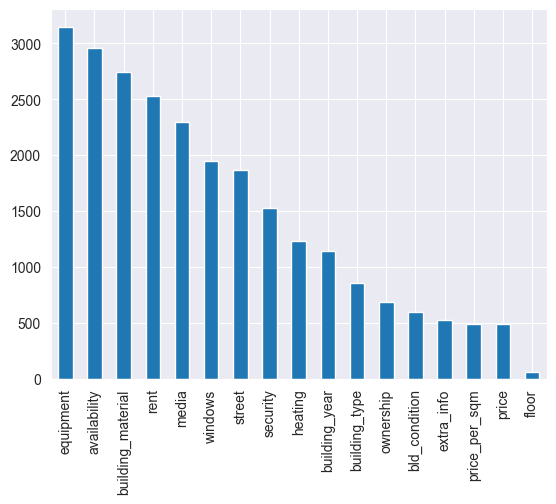

In [265]:
# NaN -> building_type, building_material, windows, media, security, equipment
df_og.replace('NaN', None, inplace=True)
df_og.isna().sum()
def missing_data_bar_plot(df):
    missing_train = df.isnull().sum()
    missing_train = missing_train[missing_train > 0]
    missing_train.sort_values(ascending=False, inplace=True)

    return missing_train.plot.bar()

missing_data_bar_plot(df_og)

def missing_values(df):
    missing_values = df.isnull().sum()
    percent = round((missing_values/len(df)) * 100, 2)
    
    missing_data = pd.concat([missing_values, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data['Total'] > 0]
    return missing_data.sort_values('Percent', ascending=False) 
missing_values(df_og)

We have apparent deficiencies in a lot of data columns, such as: 

- target variable **price** has 10% of missing values, which means we have to drop these rows from our model and **price_per_sqm** is based on target variable so it means that we have to drop it nighter but we will do this in the later stage, for now it is interesting for me.

- **equipment**, **availability**, **builiding_material** and **rent** has **>50%** missing values so consider removing them, however **rent** feature could possibly be useful for our model so we will keep it for now. 

- **media**, **windows**, **street**, **security** has **>30%** of missing values and they are probably not crucial for model so we will remove them.

- **heating**, **building_year**, **building_type**, **ownership** , **bld_condition** can be useful insights for our model but their missing values percantage is in range 12-25% so we have to deal with it later. 
- **extra_info** has 10% of missing values but the values. The data is highly variable, and its usefulness is probably not very high so we will remove it.

- **floor** feature has low percentage of missing values we will keep it. 

In [266]:
df = df_og[df_og['price'].notna()].copy()
df = df.drop(
    columns=['equipment', 'availability', 'building_material', 'media', 'windows', 'street', 'security', 'extra_info']
)

In [267]:
df.describe().round(2).T

count         mean        std         min          25%  \
db_id          4435.0      2738.77    1654.04         2.0      1299.50   
property_id    4435.0  66212546.84  713291.07  43983758.0  66139751.00   
price          4435.0    677327.38  347041.21     28000.0    484339.85   
square         4435.0        56.47      26.81        12.5        41.91   
price_per_sqm  4435.0     12175.61    3193.31      1903.0     10248.50   
rooms          4435.0         2.57       0.97         1.0         2.00   
building_year  3319.0      2000.26      58.79        70.0      1984.00   

                       50%         75%         max  
db_id              2672.00      4072.5      5812.0  
property_id    66457992.00  66548525.0  66611144.0  
price            598200.00    748347.0   5100000.0  
square               51.18        65.3       817.0  
price_per_sqm     11632.00     13500.0     97188.0  
rooms                 2.00         3.0        10.0  
building_year      2023.00      2025.0      2027.0

In [268]:
df.replace('NaN', None, inplace=True)
df.isna().sum()

db_id               0
property_id         0
price               0
square              0
price_per_sqm       0
rooms               0
date                0
url                 0
district_1          0
district_2          0
city                0
state               0
heating           859
floor              61
rent             2044
bld_condition     591
market              0
ownership         680
seller_type         0
building_year    1116
elevator            0
building_type     573
dtype: int64

In [269]:
import re
df['rent'] = df['rent'].apply(
    lambda x: (lambda r: float(r.replace(',', '.')) if r else None)(re.sub(r'[^\d,\.]', '', x))
    if isinstance(x, str) else x)

In [270]:
df['floor'].value_counts()

floor
4/4           339
3/4           283
1/4           240
parter/4      236
2/4           225
             ... 
> 10/18         1
10/13           1
4/15            1
poddasze/6      1
3/14            1
Name: count, Length: 163, dtype: int64

In [271]:
def convert_floors(df):
    def parse(s):
        s = str(s).strip().lstrip('>').strip()
        if '/' in s:
            left, right = s.split('/', 1)
            left = left.lower().strip()
            prp = 0 if left == 'parter' else (-1 if left == 'suterena' else int(left) if left.isdigit() else None)
            bld = int(right.strip()) if right.strip().isdigit() else None
        else:
            s_low = s.lower()
            if s_low == 'parter':
                prp, bld = 0, None
            elif s_low == 'suterena':
                prp, bld = -1, None
            else:
                prp, bld = int(s) if s.isdigit() else None, None
        return prp, bld

    #  process each value in the 'floor' column and build new ones
    parsed = df['floor'].apply(parse)
    df['property_floor'] = parsed.apply(lambda x: x[0])
    df['num_floors'] = parsed.apply(lambda x: x[1])
    
    return df

convert_floors(df)
df.drop(columns=['floor'], inplace=True)
df['floor_ratio'] = round((df['property_floor'] / df['num_floors']),3)

In [272]:
df[['property_floor', 'num_floors']]

property_floor  num_floors
0                0.0         6.0
1                5.0         5.0
2                2.0         4.0
3                3.0         5.0
4                0.0         6.0
...              ...         ...
4921             1.0         4.0
4922             4.0         4.0
4923             1.0         4.0
4924             2.0         5.0
4926             1.0         4.0

[4435 rows x 2 columns]

In [273]:
df['floor_ratio']

0       0.00
1       1.00
2       0.50
3       0.60
4       0.00
        ... 
4921    0.25
4922    1.00
4923    0.25
4924    0.40
4926    0.25
Name: floor_ratio, Length: 4435, dtype: float64

In [274]:
df.dtypes

db_id               int64
property_id         int64
price             float64
square            float64
price_per_sqm     float64
rooms               int64
date               object
url                object
district_1         object
district_2         object
city               object
state              object
heating            object
rent              float64
bld_condition      object
market             object
ownership          object
seller_type        object
building_year     float64
elevator           object
building_type      object
property_floor    float64
num_floors        float64
floor_ratio       float64
dtype: object

In [275]:
def add_building_age(df):
    df['building_age'] = 2025 - pd.to_numeric(df['building_year'], errors='coerce')
    df['building_age'] = df['building_age'].fillna(-1).clip(lower=0).astype(int)
    return df

#add_building_age(df)

In [276]:
# building_year, property_floor, num_floors and rooms should be an categorical variable 
cols_to_convert = ['building_year', 'rooms', 'property_floor', 'num_floors']
df[cols_to_convert] = df[cols_to_convert].astype('object')

Features **city** and **state** has the same data in each row 'Poznan' and 'wielkopolskie' so they won't contribute anything to the model therefore they can be removed.

We don't need feature **district_2** because we got **district_1** which indicates a more precise district

We won't need the **db_id** feature either, while we'll leave the **property_id** for now, for ease of data navigation 

In [277]:
df.drop(
    columns=['city', 'state', 'district_2', 'db_id'],
    inplace=True
)

In [278]:
num_features = df.select_dtypes(include=['number']).drop(columns=['property_id'], errors='ignore').columns
cat_features = df.select_dtypes(include=['object']).columns
print(num_features)
print(cat_features)

Index(['price', 'square', 'price_per_sqm', 'rent', 'floor_ratio'], dtype='object')
Index(['rooms', 'date', 'url', 'district_1', 'heating', 'bld_condition',
       'market', 'ownership', 'seller_type', 'building_year', 'elevator',
       'building_type', 'property_floor', 'num_floors'],
      dtype='object')


# EDA


In [279]:
def numerical_data_viz(df): 
    '''
    The function generates visualizations for all numeric columns in the passed DataFrame.
    
    :param df: DataFrame containing the data for which the graphs are to be generated.
    :return: The function does not return a value, but displays a set of graphs for each numeric column.
    
    For each numerical column, the following are generated:
    - In the first column: a box plot
    - In the second column: a histogram
    - In the third column: a density plot 
    '''
    num_features = df.select_dtypes(include=['number']).columns 

    # setting the size of plot
    n_cols, n_rows = 3, len(num_features)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    
    # iteration through columns
    for i, col in enumerate(num_features):
        sns.boxplot(df[col], ax=axes[i, 0], color='skyblue')
        axes[i, 0].set_title(f'{col} - Boxplot')
        
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i, 1], color='lightgreen')
        axes[i, 1].set_title(f'{col} - Histogram')
        
        sns.kdeplot(df[col], ax=axes[i, 2], color='coral')
        axes[i, 2].set_title(f'{col} - Denisity')
        
    for ax in axes.flat:
        ax.set_ylabel('') 
        ax.set_xlabel('')
        
    plt.tight_layout()
    plt.show()
    
    
    
def scatter_viz(data, numeric_features, target_feature):
    """
    Creates scatter plots for all numeric features in the data against the target variable.
    Parameters:
        data (DataFrame): Input data containing the numeric features and the target variable.
        target_feature (str): The column name of the target variable.
    """
    n_cols = 3 
    n_rows = math.ceil(len(numeric_features) / n_cols)  

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten() 

    for i, col in enumerate(numeric_features):
        sns.scatterplot(x=col, y=target_feature, hue=target_feature, data=data, ax=axes[i], palette='Blues')

        axes[i].set_xlabel(col, size=15, labelpad=12)
        axes[i].set_ylabel(target_feature, size=15, labelpad=12)
        axes[i].legend(loc='best', prop={'size': 10})

    # Hide empty axes, if any
    for j in range(len(numeric_features), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()




def reg_viz(data, numeric_features, target_feature):
    """
    Creates scatter plots for all numeric features in the data against the target variable,
    With a trend line added.

    Parameters:
        data (DataFrame): Input data containing the numerical features and the target variable.
        target_feature (str): The column name of the target variable.
    """
    n_cols = 3
    n_rows = math.ceil(len(numeric_features) / n_cols) 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten() 

    for i, col in enumerate(numeric_features):
        sns.regplot(x=col, y=target_feature, data=data, ax=axes[i], line_kws={'color': 'red', 'linewidth': 2})
        
        axes[i].set_xlabel(col, size=15, labelpad=12)
        axes[i].set_ylabel(target_feature, size=15, labelpad=12)

    # Hide empty axes, if any
    for j in range(len(numeric_features), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [280]:
def categorical_data_viz(df, categorical_features, target_feature): 
    '''
    Visualizes categorical features with:
    1. Boxplots to show the target feature's distribution across categories.
    2. Countplots to display category frequencies.

    Parameters:
    - df: DataFrame with the data.
    - categorical_features (list): List of categorical feature names.
    - target_feature (str): Target feature name.

    '''
    #num_features = df.select_dtypes(include=['number']).columns 

    # setting the size of plot
    n_cols, n_rows = 2, math.ceil(len(categorical_features))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    
    # iteration through columns
    for i, col in enumerate(categorical_features):
         # Boxplot
        sns.boxplot(x=col, y=target_feature, data=df, ax=axes[i, 0], color='skyblue')
        axes[i, 0].set_title(f'{col} - Boxplot', fontsize=12)
        
         # Countplot
        sns.countplot(x=col, data=df, ax=axes[i, 1], palette='Set2')
        axes[i, 1].set_title(f'{col} - Countplot', fontsize=12)
        
        
    for ax in axes.flat:
        ax.set_ylabel('') 
        ax.set_xlabel('')
        
    plt.tight_layout()
    plt.show()

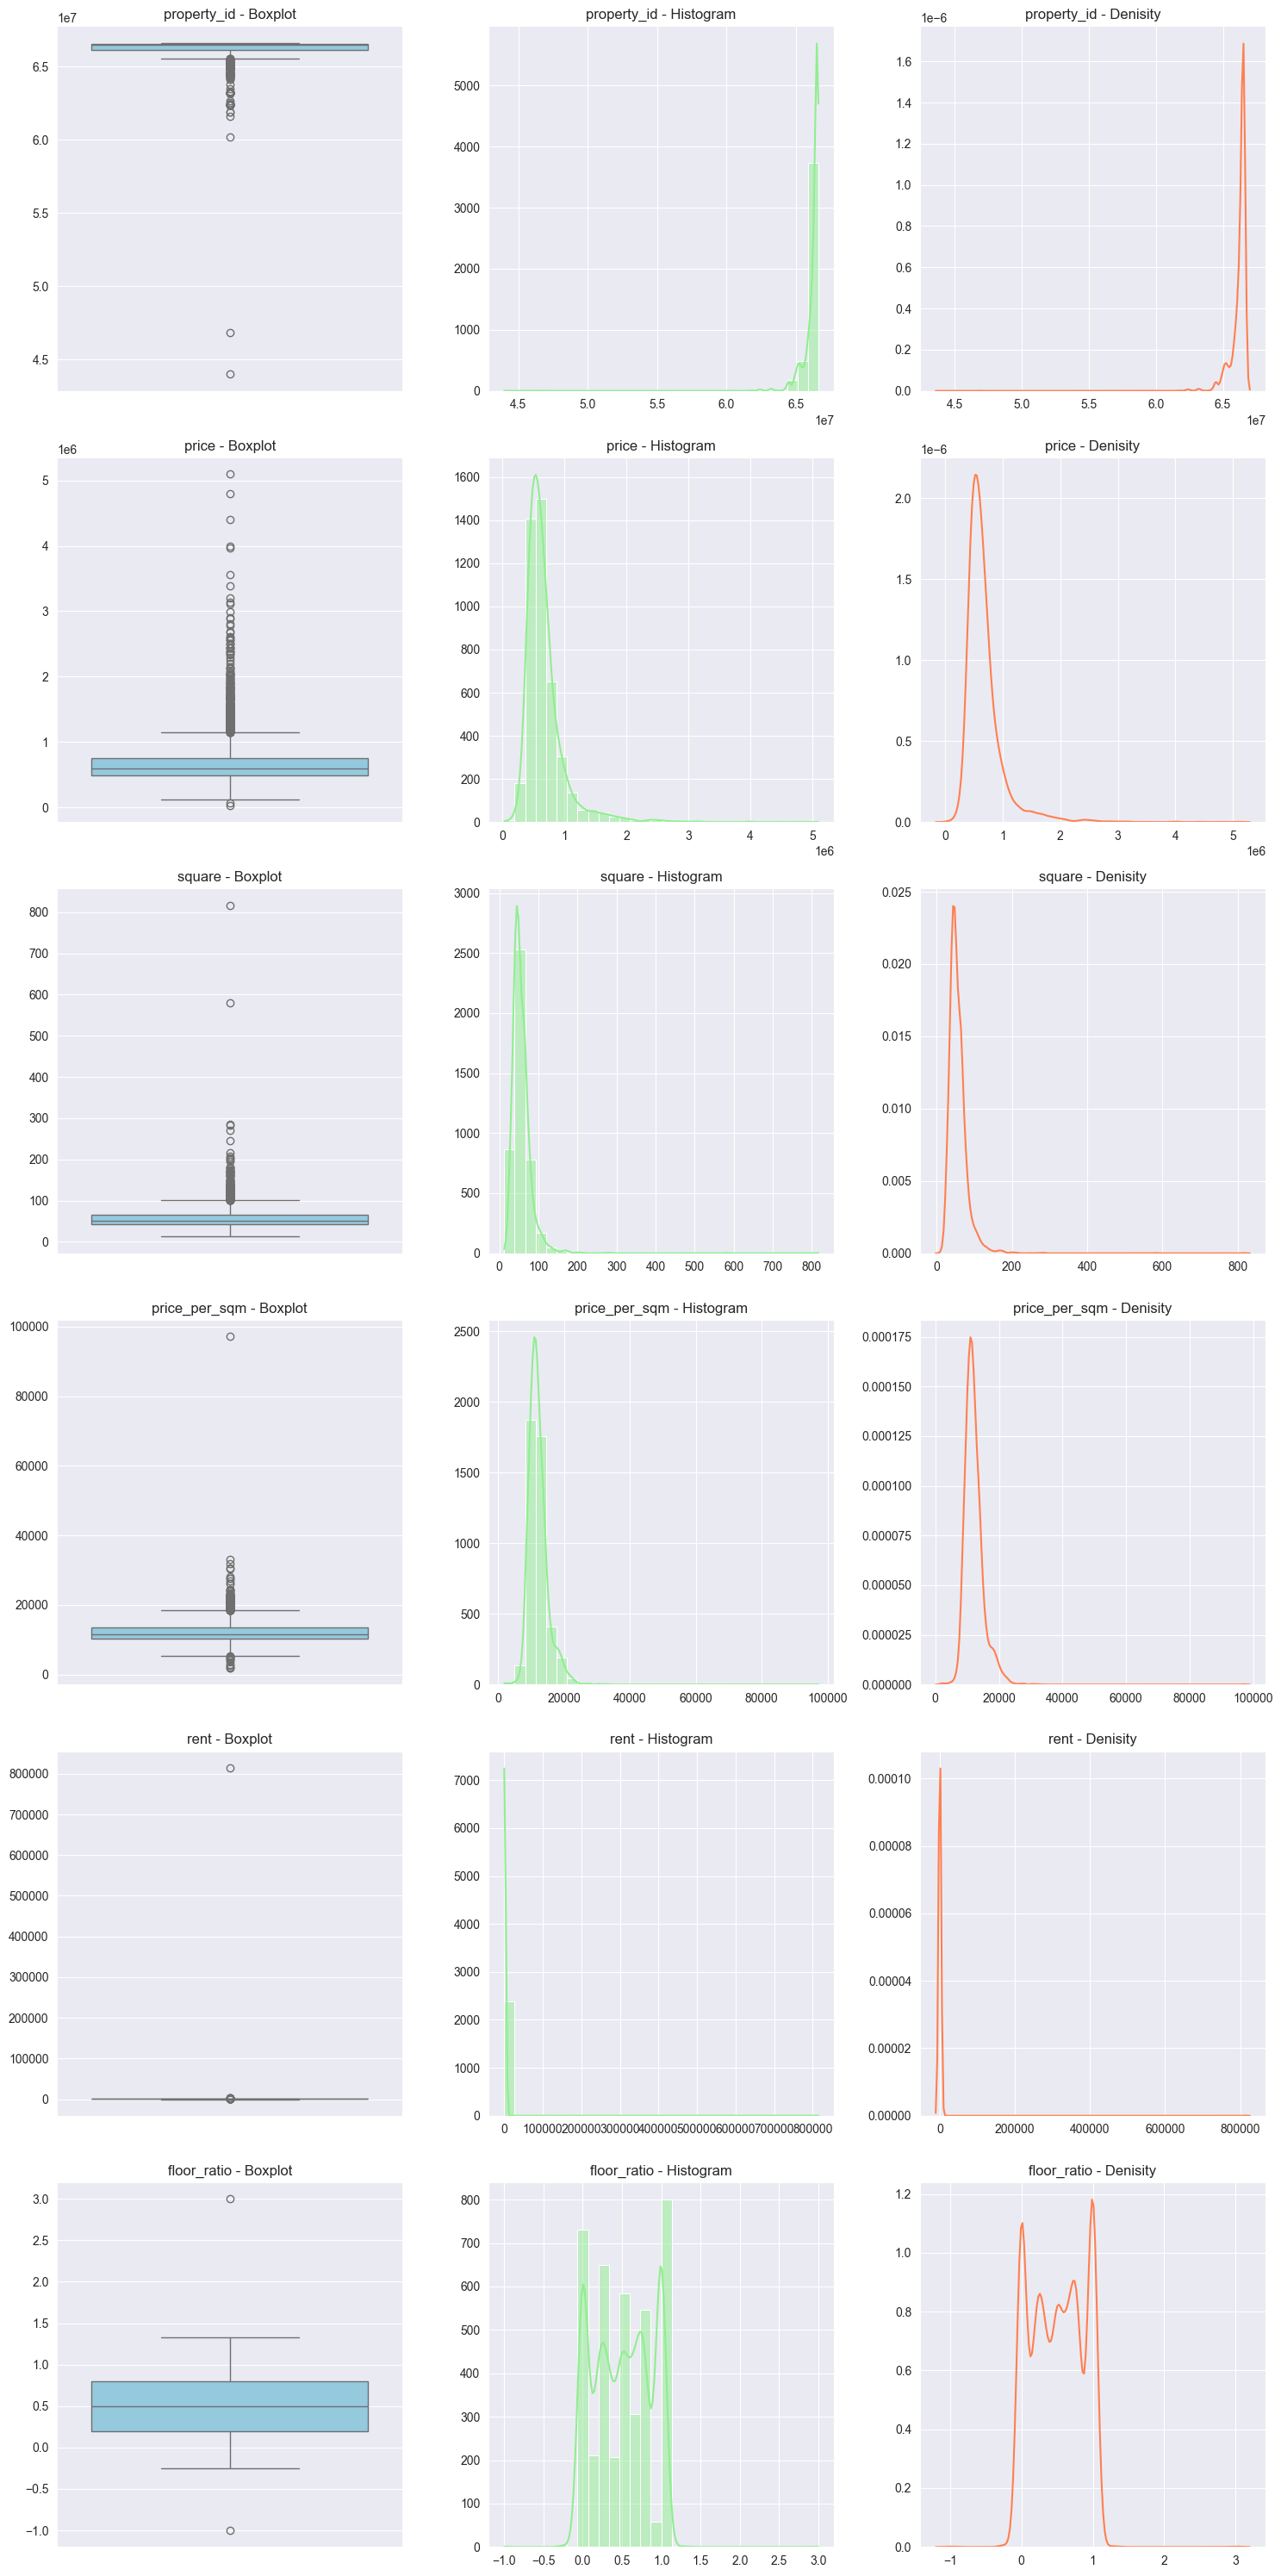

In [281]:
numerical_data_viz(df)

In [282]:
#categorical_data_viz(df, cat_features, 'price')

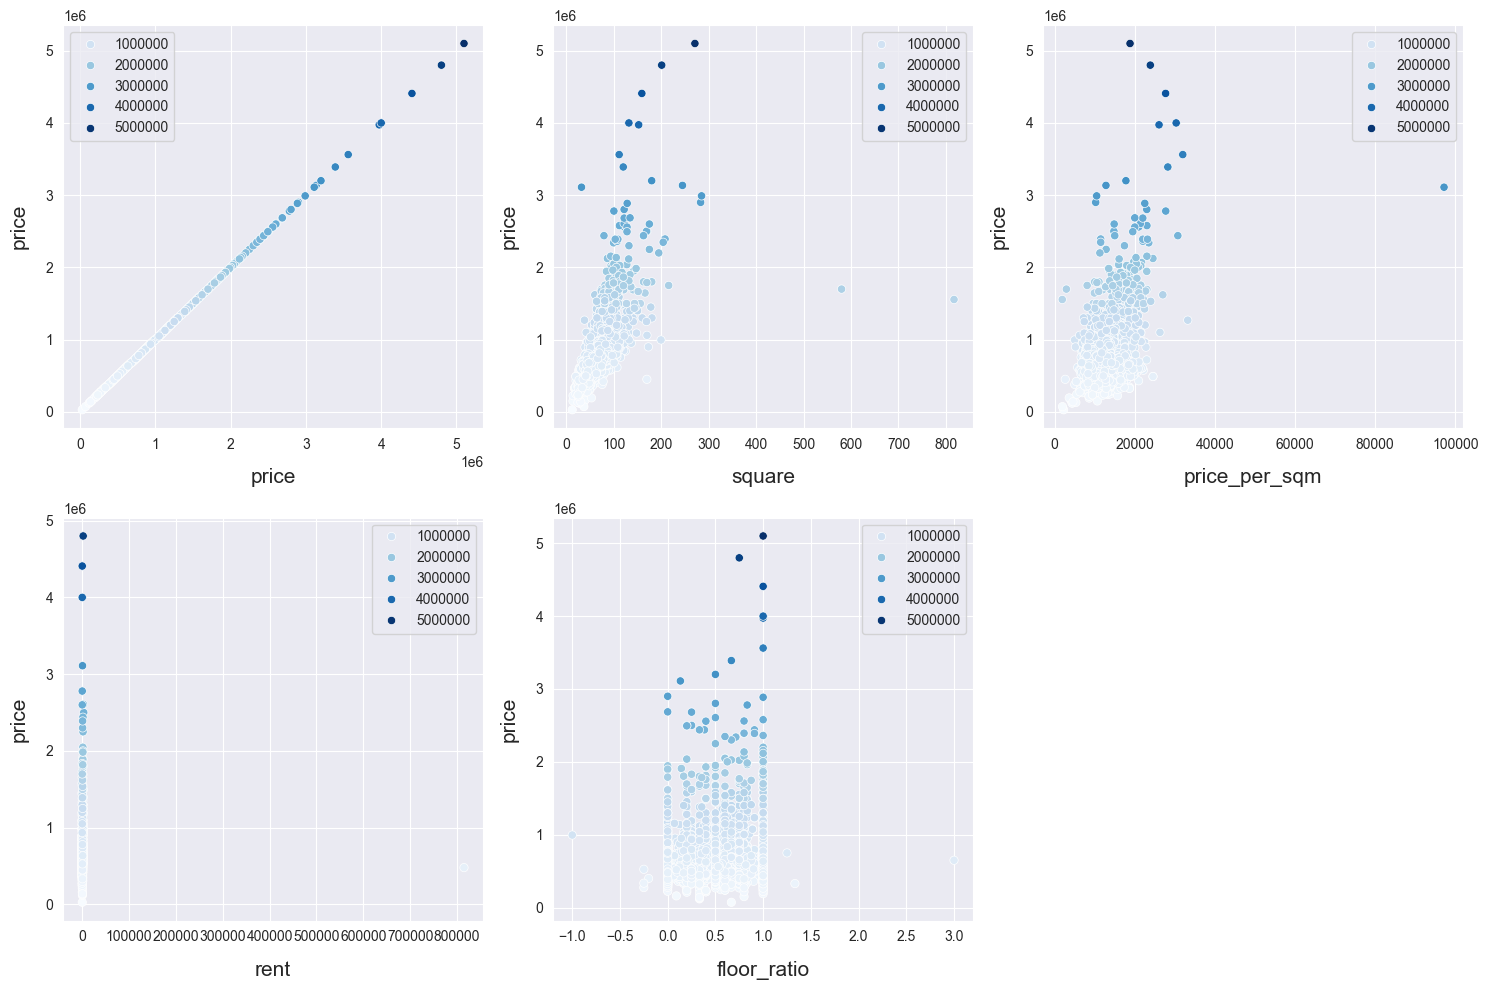

In [283]:
scatter_viz(df, num_features, 'price')

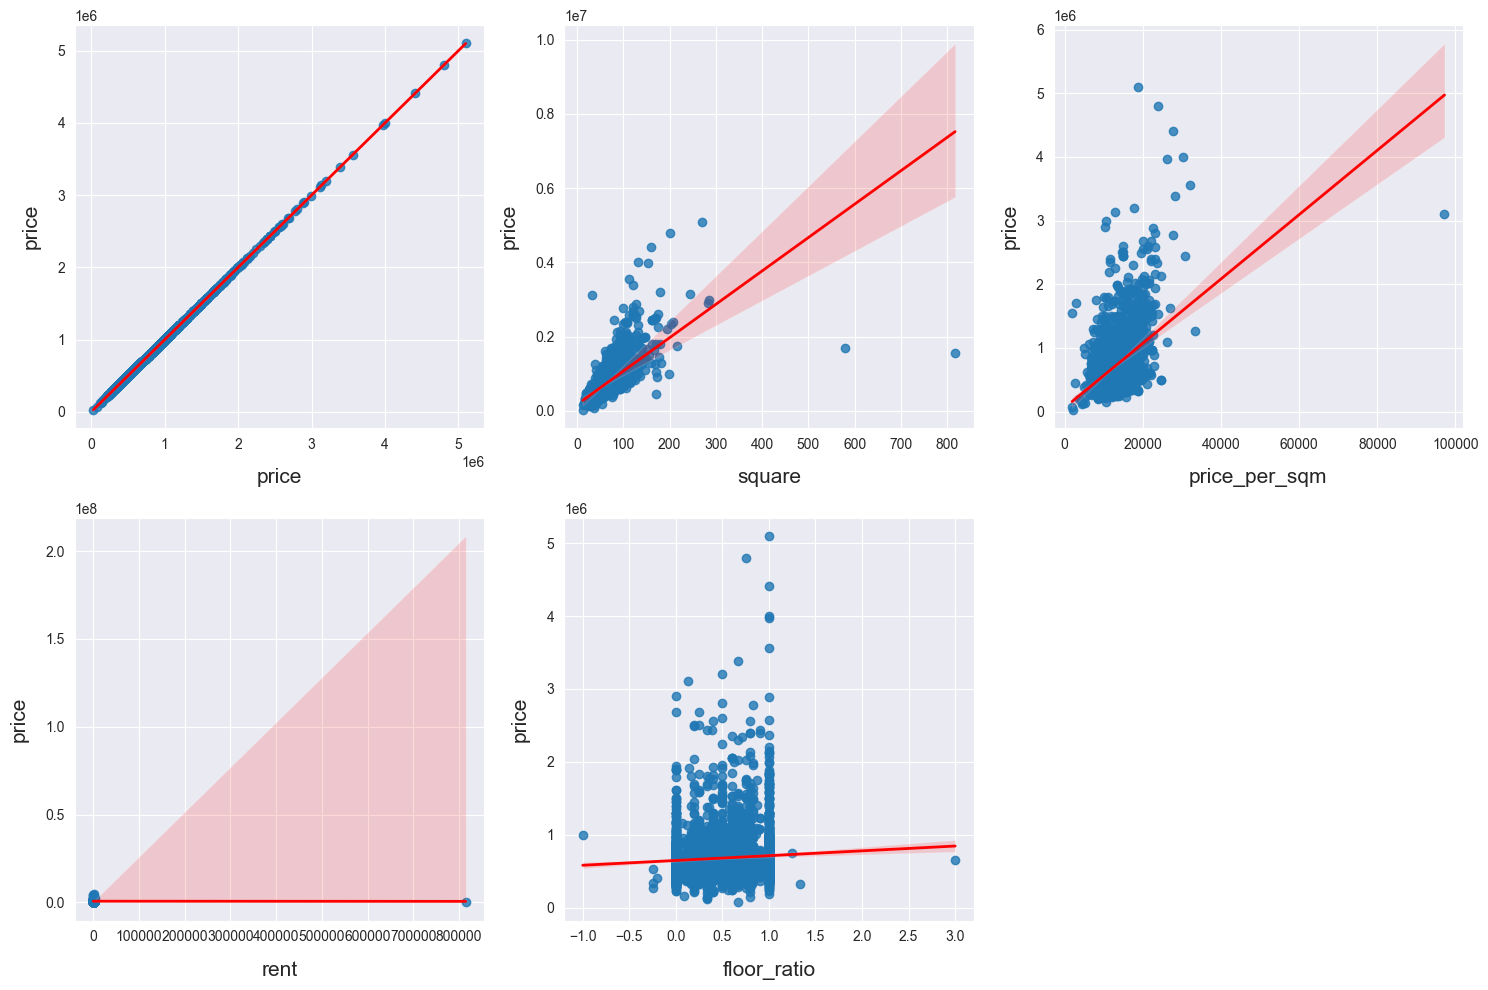

In [284]:
reg_viz(df, num_features, 'price')

## Deal with data having errors
Some data points looks like anomaly so probably has errors occurred by users or by scraping algorithms

In [285]:
df[df['rent'] > 10000] # this rent price was way too high so I decided to change it to None value
df.loc[3770, 'rent'] = None
df.query("property_id == 66384406")

property_id     price  square  price_per_sqm rooms        date  \
3770     66384406  480000.0    47.8        10042.0     3  2025-03-18   

                                                    url district_1   heating  \
3770  https://www.otodom.pl/pl/oferta/trzypokojowe-n...     Rataje  miejskie   

      rent    bld_condition  market                         ownership  \
3770   NaN  do zamieszkania  wtórny  spółdzielcze wł. prawo do lokalu   

              seller_type building_year elevator building_type property_floor  \
3770  biuro nieruchomości           NaN      nie          blok            1.0   

     num_floors  floor_ratio  
3770        4.0         0.25

In [286]:
df[df['price_per_sqm'] > 35000] # we got mistake in price of this property, unfortunately it's changed and by the URL link we can't see this offer, so I will delete this property
df.drop(df[df['price_per_sqm'] > 35000].index, inplace=True)

In [287]:
df[df['building_year'] < 1800] 
# year == 70 means probably that's apartment from 70s, but I can't confirm that so I will give a None value
# year == 1664 is also a mistake based on inquiry so it will get None as well
# year == 202 is mistake it will get None
df.loc[df['building_year'] < 1800, 'building_year'] = None

In [288]:
# Model should work well for apartments, so apartments bigger than 300 sqm are anomaly worth to check 
df[df['square'] > 300] # these listings are houses converted into apartments or commercial premises, I am not able to separate this well into several listings
df.drop(df[df['square'] > 300].index, inplace=True)

In [289]:
# We deal with apartments that has some errors with num_floors, eg. The apartment is on floor 3, and the building has a total of 1 floor
df.loc[[3859,3958,4067], ['num_floors', 'floor_ratio']] = None
df.loc[191, 'floor_ratio'] = None
df.query("property_id == 66435355")

property_id     price  square  price_per_sqm rooms        date  \
3859     66435355  648875.0   44.75        14500.0     2  2025-03-18   

                                                    url district_1   heating  \
3859  https://www.otodom.pl/pl/oferta/jezyce-nowe-mi...     Ogrody  miejskie   

       rent   bld_condition  market       ownership          seller_type  \
3859  650.0  do wykończenia  wtórny  pełna własność  biuro nieruchomości   

     building_year elevator building_type property_floor num_floors  \
3859        2024.0      nie          blok            3.0       None   

      floor_ratio  
3859          NaN

In [290]:
df['building_type'].value_counts()

building_type
blok                2578
kamienica            686
apartamentowiec      523
dom wolnostojący      35
szeregowiec           26
plomba                11
Name: count, dtype: int64

In [291]:
df['heating'].value_counts()

heating
miejskie         2739
gazowe            424
inne              305
kotłownia          62
elektryczne        37
piece kaflowe       6
Name: count, dtype: int64

In [292]:
df['bld_condition'].value_counts()

bld_condition
do zamieszkania    1788
do wykończenia     1777
do remontu          276
Name: count, dtype: int64

In [293]:
df['building_type'].value_counts()

building_type
blok                2578
kamienica            686
apartamentowiec      523
dom wolnostojący      35
szeregowiec           26
plomba                11
Name: count, dtype: int64

In [294]:
df_grouped = df.groupby('district_1').agg(
                    num_properties = ('property_id', 'count'),
                    avg_price = ('price', 'mean'),
                    avg_square = ('square', 'mean'),
                    avg_price_per_sqm = ('price_per_sqm', 'mean'),
                    avg_rent = ('rent', 'mean'),
                    avg_floor_ratio = ('floor_ratio', 'mean')
                ).reset_index()
df_filtered = df_grouped.query("num_properties > 20").round(2)
df_filtered

district_1  num_properties   avg_price  avg_square  \
2                Centrum             235   881994.49       58.25   
3               Chartowo              47   590290.43       58.33   
9                 Dębiec              43   525062.79       48.16   
14              Grunwald             205   704802.60       60.18   
15               Górczyn              49   644167.35       56.90   
18                Główna              66   427433.47       40.05   
19                Jeżyce             560   723266.88       57.80   
20              Junikowo             203   688798.61       58.38   
21           Kasztelanów              88   766103.37       56.48   
23            Komandoria              30   628366.63       47.68   
29                 Luboń              26   456706.08       51.91   
35            Naramowice             163   616637.88       53.00   
36            NoweMiasto             388   554782.61       50.59   
40              Piątkowo             186   616073.76       58.11   
41              Plewiska              30   542019.80       58.97   
42              Podolany             103   607750.16       51.17   
44                Raszyn              51   591625.53       54.42   
45                Rataje              96   532499.57       48.63   
49                Sołacz              34  1130498.41       67.43   
50           StareMiasto             483   684625.47       55.91   
51         StarołękaMała             125   655637.79       55.08   
53             Strzeszyn              52   690429.25       58.47   
59                Szeląg              29   720495.52       58.36   
61                 Wilda             299   714460.63       57.97   
62               Winiary              40   616145.75       51.62   
63             Winogrady             226   590001.87       49.84   
72  os.MikołajaKopernika              35   551220.00       58.94   
79                Łacina              45   908319.56       69.74   
80                Ławica              26   824452.00       68.55   
81                Łazarz             145   836801.24       66.65   
87                Żegrze              37   589524.46       60.35   

    avg_price_per_sqm  avg_rent  avg_floor_ratio  
2            15114.99    405.12             0.53  
3            10263.40    691.97             0.53  
9            11142.44    597.09             0.60  
14           11877.58    553.85             0.48  
15           11739.49    546.59             0.48  
18           10650.50    454.93             0.57  
19           12925.67    470.72             0.45  
20           11923.03    501.97             0.50  
21           13710.66    437.79             0.47  
23           13666.67    428.62             0.39  
29            8834.62    174.55             0.85  
35           11901.95    524.49             0.46  
36           11021.50    549.62             0.48  
40           10814.87    681.27             0.51  
41            9322.60    258.54             0.56  
42           12098.83    392.40             0.51  
44           11169.63    616.66             0.39  
45           11093.94    636.01             0.62  
49           16440.88    469.60             0.47  
50           12482.69    597.41             0.54  
51           12002.15    460.22             0.46  
53           11975.54    439.31             0.53  
59           12388.79    677.73             0.46  
61           12437.88    513.57             0.53  
62           11996.72    626.06             0.60  
63           11785.85    631.65             0.52  
72            9688.20    847.91             0.56  
79           13227.00    754.00             0.37  
80           12002.58    265.00             0.34  
81           12495.26    553.49             0.52  
87            9938.08    793.20             0.53

To avoid inflating single listings, I decided to check only those neighborhoods that have >20 real estate sales listings. 

1. **Prices** are highest in the center and around Sołacz, and lowest on the outskirts (Luboń, Plewiska).
2. **Price per sqm** varies widely by district - a key metric for investors.
3. **Rents** do not always go hand in hand with price - expensive Sołacz, for example, has a relatively high rent, but Łazarz, for example, no longer.

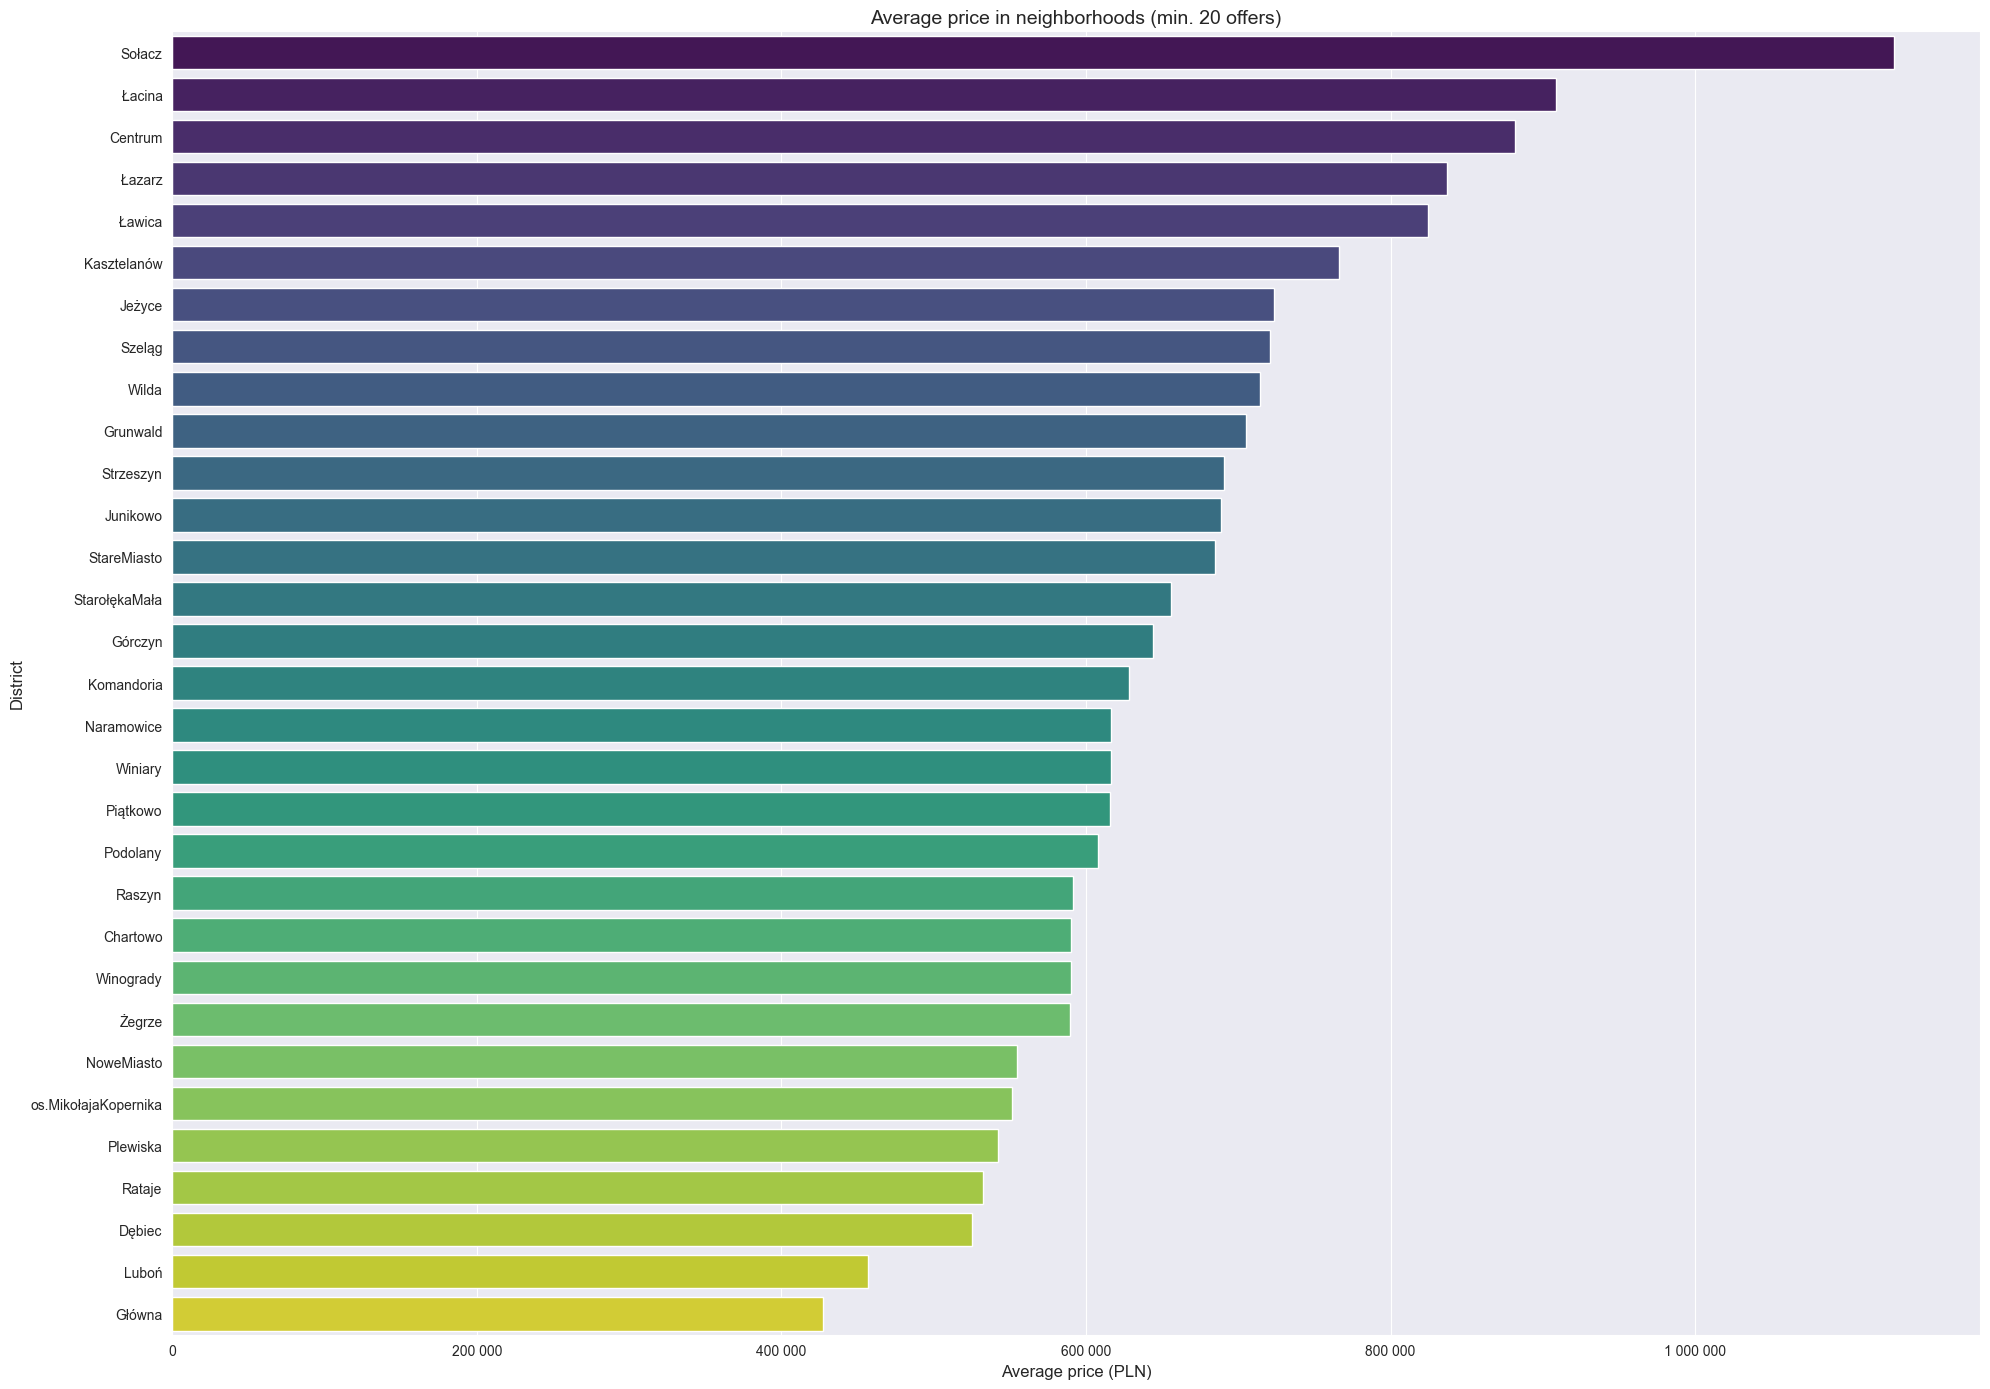

In [295]:
from matplotlib.ticker import FuncFormatter

df_sorted_avg_price = df_filtered.sort_values(by='avg_price', ascending=False)

plt.figure(figsize=(20,14))
sns.barplot(
    data=df_sorted_avg_price,
    x='avg_price',
    y='district_1',
    palette='viridis'
)
plt.title('Average price in neighborhoods (min. 20 offers)', fontsize=14)
plt.xlabel('Average price (PLN)', fontsize=12)
plt.ylabel('District', fontsize=12)
formatter = FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' '))
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

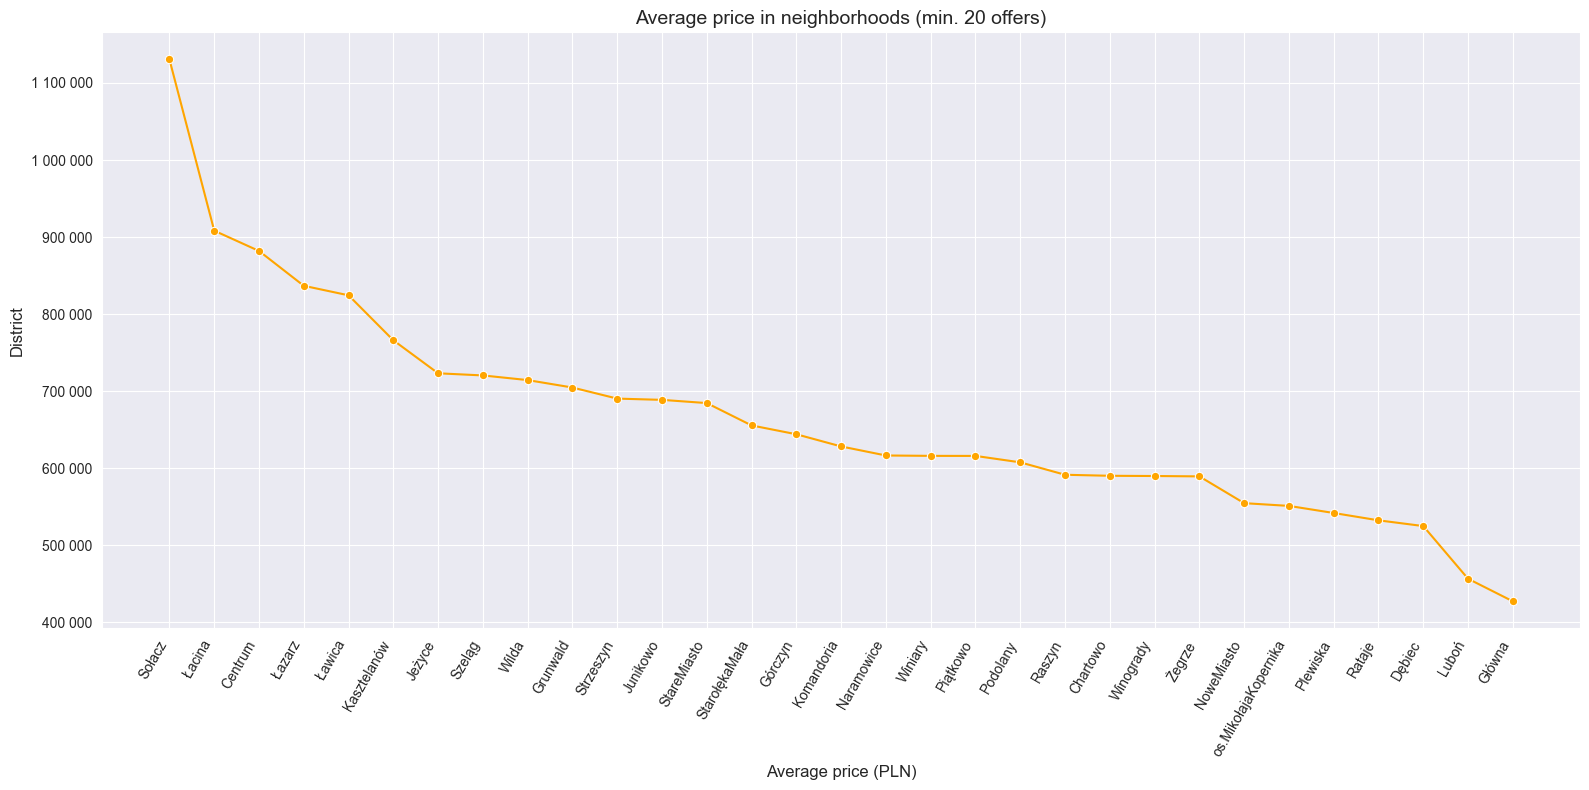

In [296]:
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=df_sorted_avg_price,
    x='district_1',
    y='avg_price',
    marker='o',
    color='orange',
)

plt.xticks(rotation=60, ha='right')

plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Average price in neighborhoods (min. 20 offers)', fontsize=14)
plt.xlabel('Average price (PLN)', fontsize=12)
plt.ylabel('District', fontsize=12)

plt.tight_layout()
plt.show()

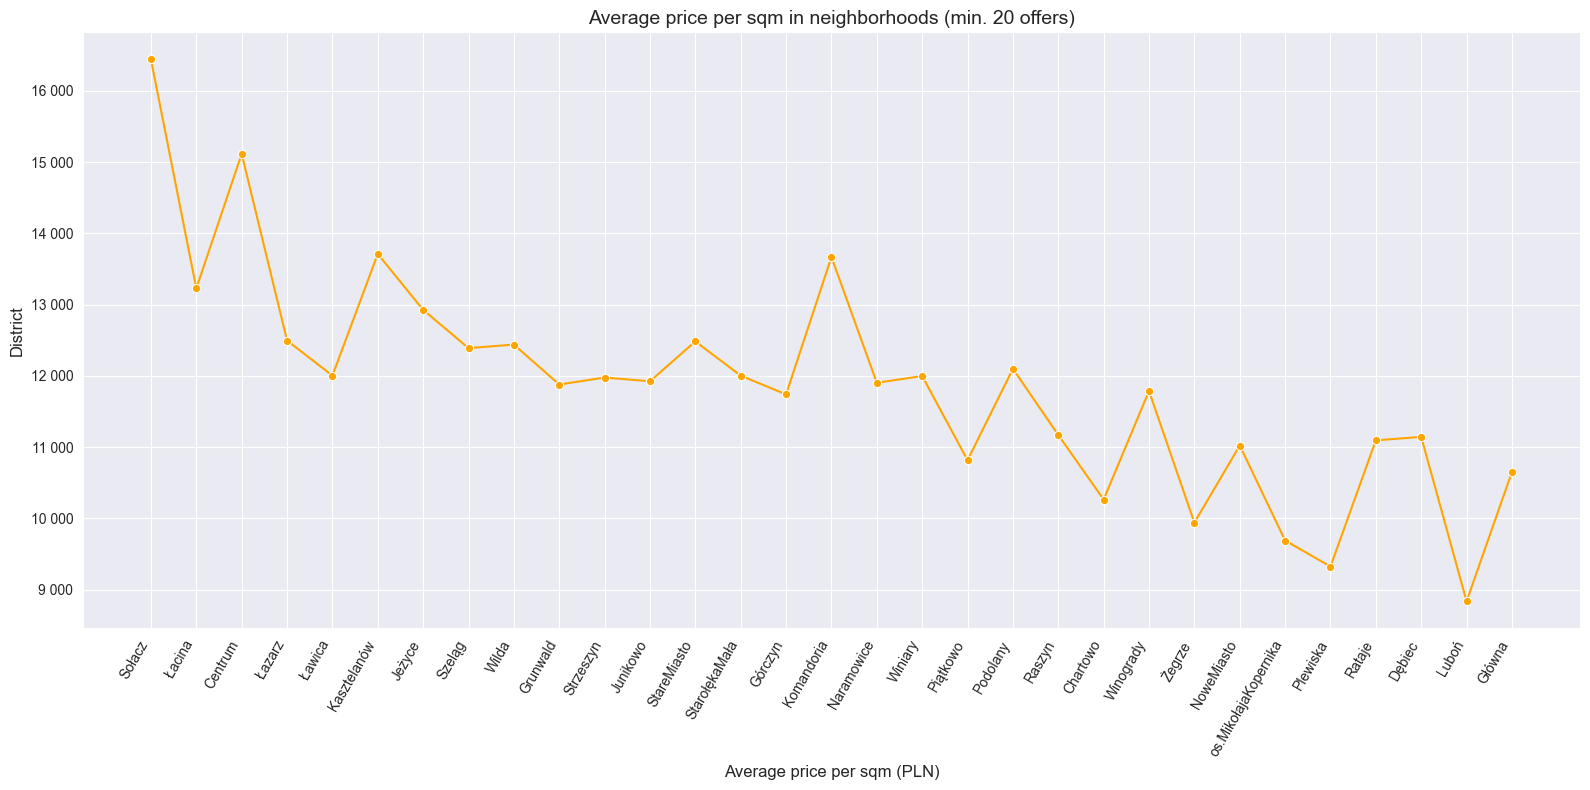

In [297]:
df_sorted_avg_price_per_sqm = df_filtered.sort_values(by='avg_price_per_sqm', ascending=False)
plt.show()
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=df_sorted_avg_price,
    x='district_1',
    y='avg_price_per_sqm',
    marker='o',
    color='orange',
)

plt.xticks(rotation=60, ha='right')

plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Average price per sqm in neighborhoods (min. 20 offers)', fontsize=14)
plt.xlabel('Average price per sqm (PLN)', fontsize=12)
plt.ylabel('District', fontsize=12)

plt.tight_layout()
plt.show()

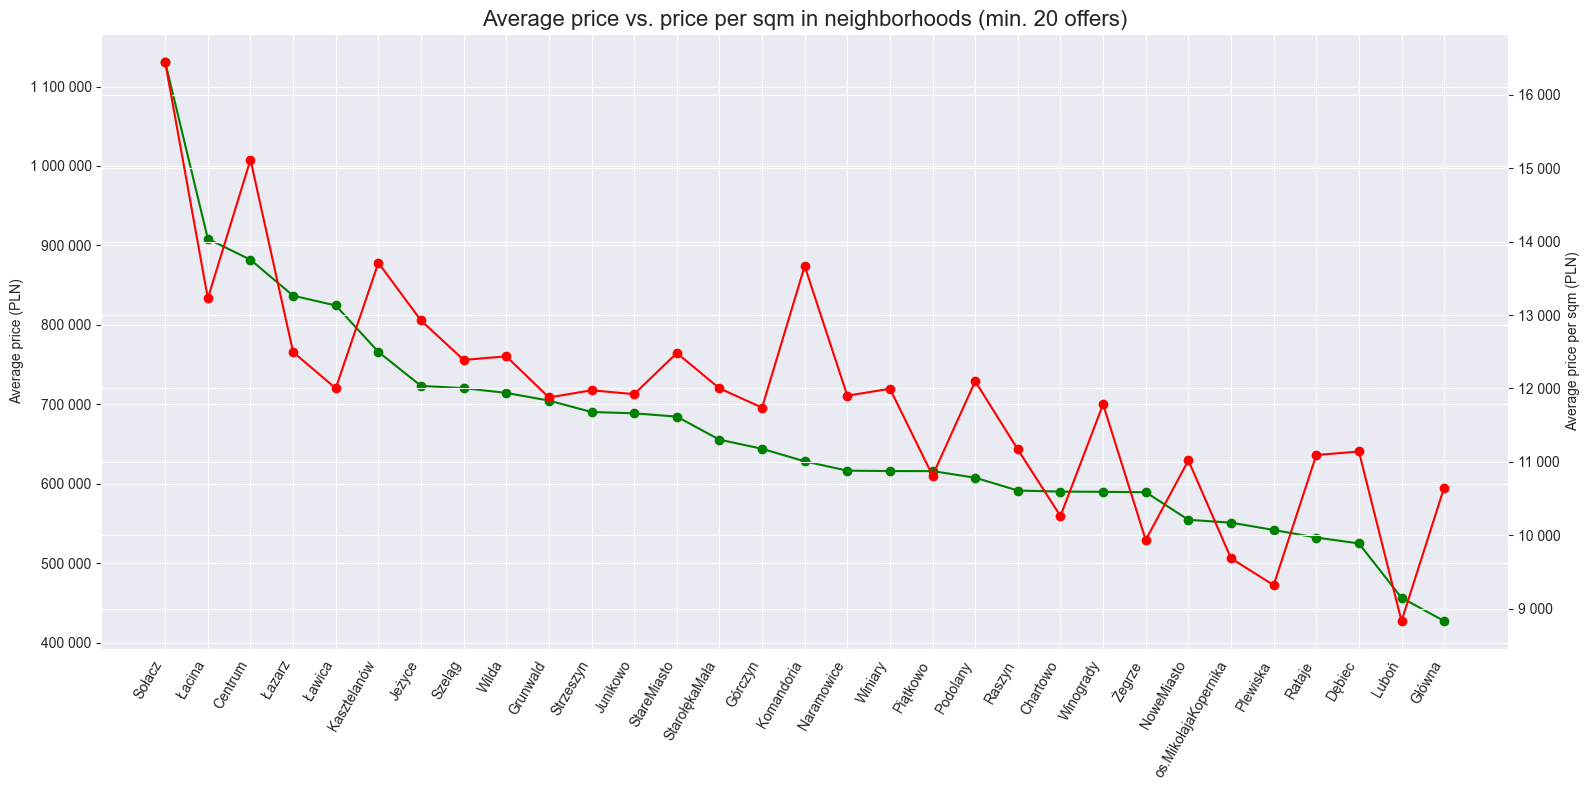

In [298]:
df_sorted = df_filtered.sort_values(by='avg_price', ascending=False)

# X axis
districts = df_sorted['district_1']
x = range(len(districts))

# graph with two Y axes
fig, ax1 = plt.subplots(figsize=(16, 8))

# Green graph: avg_price (left Y axis)
ax1.plot(x, df_sorted['avg_price'], color='green', marker='o', label='Average price')
ax1.set_ylabel('Average price (PLN)')
ax1.tick_params(axis='y')
ax1.set_xticks(x)
ax1.set_xticklabels(districts, rotation=60, ha='right')
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' '))) # Y-axis formatting (left)

# Red Y axis: avg_price_per_sqm
ax2 = ax1.twinx()
ax2.plot(x, df_sorted['avg_price_per_sqm'], color='red', marker='o', label='Price per sqm')
ax2.set_ylabel('Average price per sqm (PLN)')
ax2.tick_params(axis='y')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' '))) # Y-axis formatting (right)

plt.title('Average price vs. price per sqm in neighborhoods (min. 20 offers)', fontsize=16)
plt.tight_layout()
plt.show()

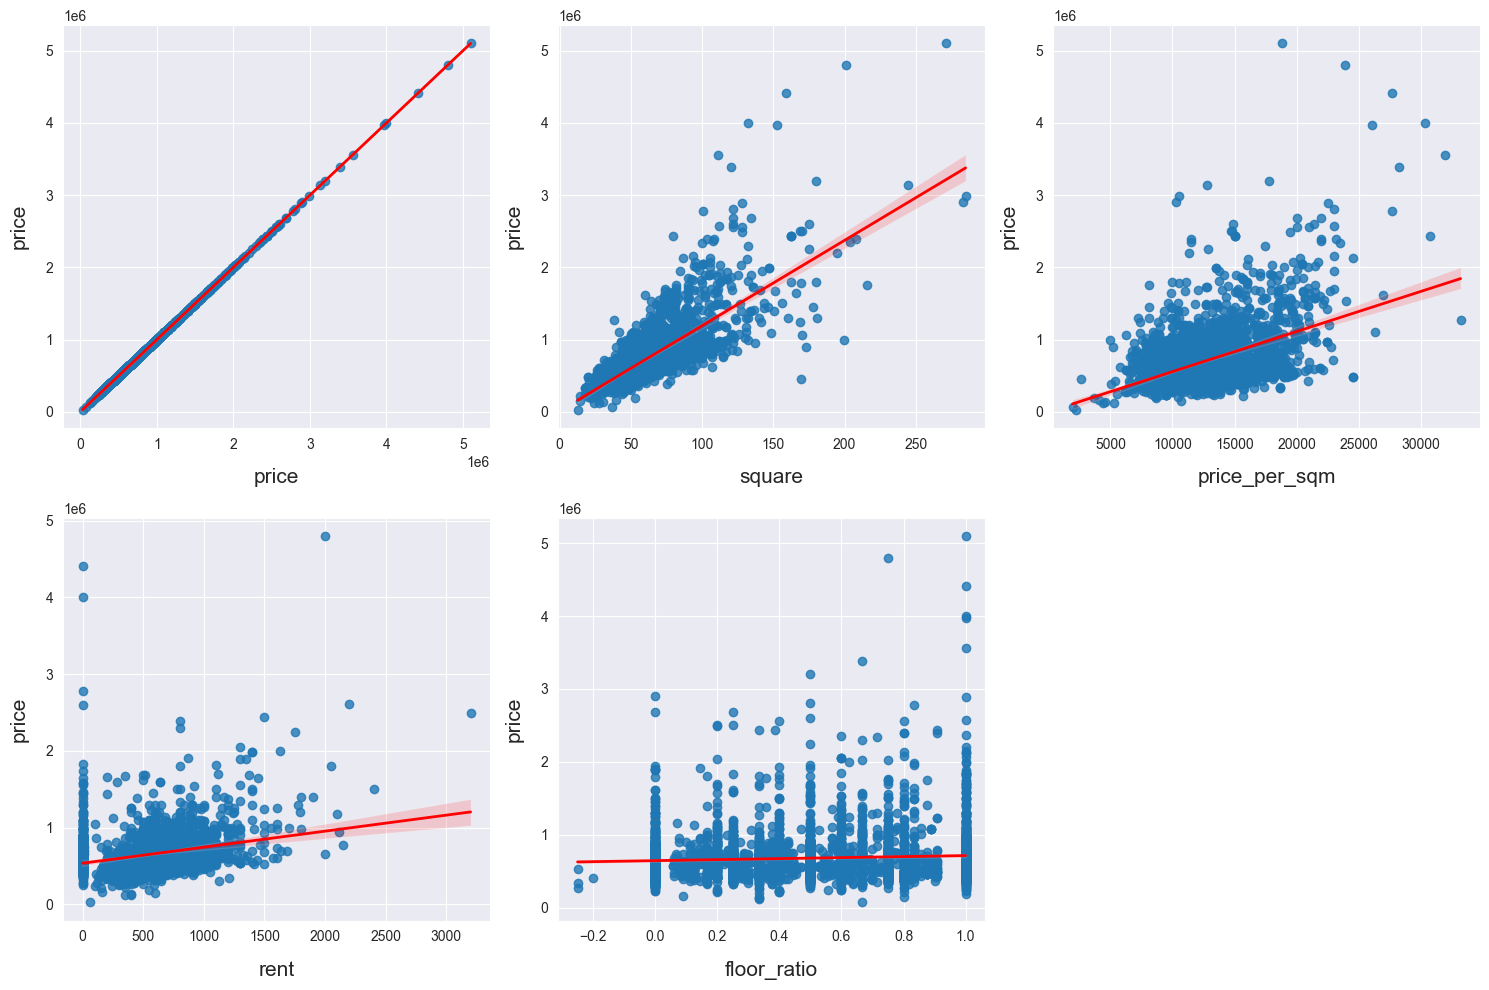

In [299]:
reg_viz(df, num_features, 'price')

The removed conspicuous misplaced values have made the regplot's look much better and we can draw better conclusions from them, such as: 

`square` vs `price`
- Clear **positive linear relationship**.
- Higher square footage strongly correlates with higher property prices.

`price_per_sqm` vs `price`
- Weak to moderate **positive trend**, but lots of spread and outliers.
- This feature is derived from `price` itself (`price / square`) so including it causes **data leakage**

`floor_ratio` vs `price`
- No clear linear relationship. Data is heavily clustered with some vertical streaks.
- Regression line is nearly flat.
- Might be useful in nonlinear models, but low predictive power on its own.

`rent` vs `price`
- Weak **positive relationship**.
- Some clusters with high variance, but trend line still slopes upward.



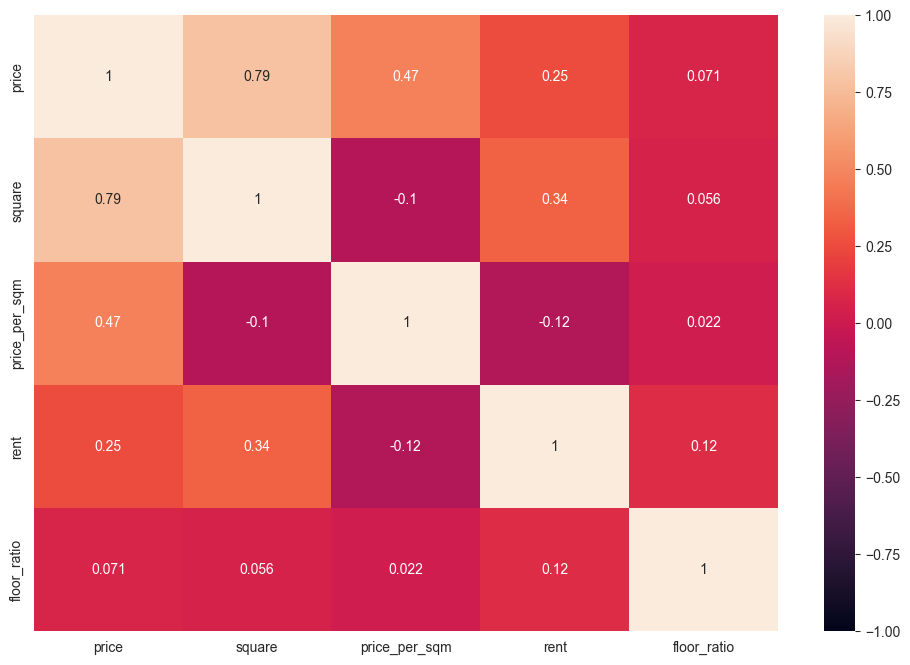

In [300]:
corr = df[num_features].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True ,vmin= -1, vmax= 1)
plt.show()

### Correlation Heatmap Analysis

**Target Variable: `price`**

This heatmap shows the Pearson correlation coefficients between the target variable `price` and other numerical features. Here's a breakdown:

**Strong Correlations**

- **`square` (0.79)**  
  Strong positive correlation. Larger properties tend to have higher prices.  
- **`price_per_sqm` (0.47)**  
  Moderate correlation, **but derived from the target**: `price / square`.  
  **Should be excluded** from the model to avoid data leakage.

**Moderate or Weak Correlations**

- **`rent` (0.25)**  
  Weak-to-moderate correlation. Rent prices can reflect market value.  
- **`floor_ratio` (0.07)**  
  Very weak correlation with price. Possibly useful in nonlinear models.  

**Negative or Irrelevant Correlations**
- **`price_per_sqm` vs `square` (-0.10)**  
  Negative relationship expected (larger properties usually have a lower price per m²).
- Other correlations are close to 0 → not meaningful for prediction in linear models.

In [301]:
df.drop(columns=['price_per_sqm'], inplace=True)

### Feature engineering


In [302]:
def calculate_building_age(df):
    building_year_numeric = pd.to_numeric(df['building_year'], errors='coerce')
    # conditions:
    # - if NaN → -1
    # - if year > 2025 → 0
    # - otherwise: 2025 - year
    df['building_age'] = building_year_numeric.apply(
        lambda x: -1 if pd.isna(x) else 0 if x > 2025 else 2025 - x
    ).astype(int)

    return df

df = calculate_building_age(df)
df['building_year'] = df['building_year'].astype(str)

In [303]:
# Number of offers in the district (may indicate competition)
def calculate_district_popularity(df):
    district_counts = df['district_1'].value_counts()
    df['district_popularity'] = df['district_1'].map(district_counts)
    return df

df = calculate_district_popularity(df)

## Missing values

Total  Percent
rent             2044    46.12
heating           859    19.38
ownership         679    15.32
bld_condition     591    13.33
building_type     573    12.93
floor_ratio       336     7.58
num_floors        332     7.49
property_floor     63     1.42

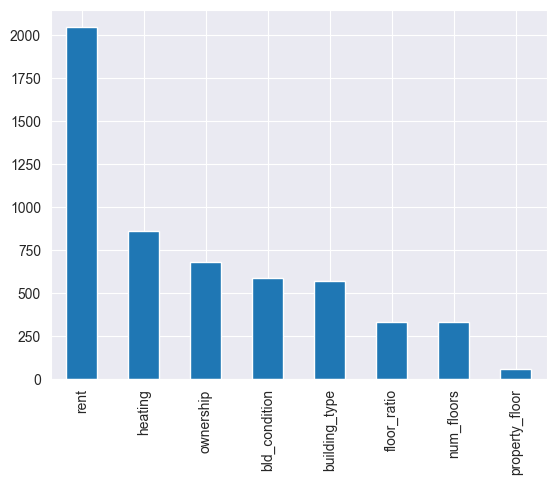

In [304]:
missing_data_bar_plot(df)
missing_values(df)

### Strategy for filling in missing data 

1. floor_ratio, num_floors, property_floor will fill by median values, since their deficiencies account for <10% of all data
2. building_year, heating, ownership, bld_condition as categorical variables in missing data will get 'unknown'
3. The variable rent will be completed with a predictive model 


In [305]:
#1
floor_cols = ['floor_ratio', 'num_floors', 'property_floor']
df.loc[:, floor_cols] = df[floor_cols].fillna(df[floor_cols].median())

#2
unknown_cols = ['building_year', 'building_type', 'heating', 'ownership', 'bld_condition']
df.loc[:, unknown_cols] = df[unknown_cols].fillna('unknown')

In [306]:
df.columns

Index(['property_id', 'price', 'square', 'rooms', 'date', 'url', 'district_1',
       'heating', 'rent', 'bld_condition', 'market', 'ownership',
       'seller_type', 'building_year', 'elevator', 'building_type',
       'property_floor', 'num_floors', 'floor_ratio', 'building_age',
       'district_popularity'],
      dtype='object')

In [307]:
df['rent'].describe()

count    2388.000000
mean      549.796382
std       355.752578
min         0.000000
25%       350.000000
50%       550.000000
75%       750.000000
max      3200.000000
Name: rent, dtype: float64

In [308]:
#3 rent feature
features = ['price', 'square', 'rooms', 'building_age']

rent = df[df['rent'].notna()]
missing_rent = df[df['rent'].isna()]

X_train = rent[features]
y_train = rent['rent']
X_missing = missing_rent[features]

# Model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

predicted_rent = model.predict(X_missing)
# adding new data to the dataframe
df.loc[df['rent'].isna(), 'rent'] = predicted_rent

## Data preprocessing

At this stage of the project we dont need property_id, date and URL anymore

In [309]:
df.drop(
    columns = ['url', 'date', 'property_id'],
    axis=1,
    inplace=True
)

In [310]:
categorical_features = df.select_dtypes(include=['object']).columns
numeric_features = df.select_dtypes(include=['number']).columns
print(categorical_features)
print(numeric_features)

Index(['rooms', 'district_1', 'heating', 'bld_condition', 'market',
       'ownership', 'seller_type', 'building_year', 'elevator',
       'building_type', 'property_floor', 'num_floors'],
      dtype='object')
Index(['price', 'square', 'rent', 'floor_ratio', 'building_age',
       'district_popularity'],
      dtype='object')


In [311]:
original_features = []
original_features.append(categorical_features)
original_features.append(numeric_features)
print(original_features)

[Index(['rooms', 'district_1', 'heating', 'bld_condition', 'market',
       'ownership', 'seller_type', 'building_year', 'elevator',
       'building_type', 'property_floor', 'num_floors'],
      dtype='object'), Index(['price', 'square', 'rent', 'floor_ratio', 'building_age',
       'district_popularity'],
      dtype='object')]


### Split of data into training and test data

In [312]:
X = df.drop('price', axis=1)
y = df['price']

Skewness: 3.887714
Kurtosis: 26.830896


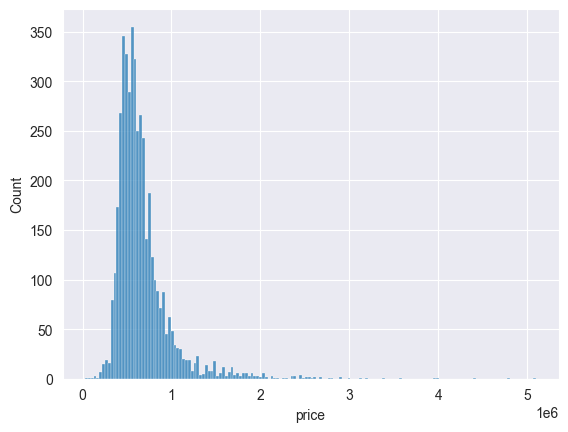

In [313]:
sns.histplot(y)
print("Skewness: %f" %y.skew())
print("Kurtosis: %f" %y.kurt())

In [314]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X , y ,test_size = 0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3545, 17), (887, 17), (3545,), (887,))

In [315]:
numeric_features = [col for col in numeric_features if col in X_train.columns]
categorical_features = [col for col in categorical_features if col in X_train.columns]

In [316]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

preprocessor = ColumnTransformer(transformers=[
    ('num', RobustScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Building ML models

### Pipelines


In [230]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Linear regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Lasso
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# Random Forrest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# Cat Boost
catboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(random_state=42, verbose=False))
])

# Light GBM
light_gbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=42, force_col_wise=True))
])

# Support Vector Regressor
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

### Grid params


In [231]:
param_grid_lr = {
    'regressor__fit_intercept': [True, False]
}

param_grid_lasso = {
    'regressor__alpha': [ 0.01, 0.1, 0.5, 1.0, 2.0,],
    'regressor__fit_intercept': [True, False],
    'regressor__max_iter': [500, 1000, 2000, 5000, 10000],
    'regressor__tol' : [1e-3]
}

param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200, 300, 500],
    'regressor__max_depth': [5, 6, 7, 8],
    'regressor__min_samples_split': [2, 4, 6],
    'regressor__min_samples_leaf': [1, 2, 3],
    'regressor__bootstrap': [True, False],
}

param_grid_xgb = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [4, 5, 6, 7, 8],
    'regressor__learning_rate': [0.5, 1.0, 3.0],
    'regressor__subsample' : [0.5, 0.7, 0.9, 1.0],
}

param_grid_catboost = {
    'regressor__iterations': [300, 500, 1000, 2000],
    'regressor__learning_rate': [0.01 ,0.1, 0.2, 0.5],
    'regressor__depth': [4, 5, 6, 7, 8],
    'regressor__l2_leaf_reg': [1.0, 2.0, 5.0],
}

param_grid_lightgbm = {
    'regressor__n_estimators': [50, 100, 200, 300, 500],
    'regressor__learning_rate': [0.01 ,0.1, 0.2, 0.4],
    'regressor__depth': [3,4, 5, 6, 7, 8],
}

param_grid_svr = {
    'regressor__kernel': ['rbf', 'linear'],
    'regressor__C' : [0.5, 1 , 1.5]
}

In [232]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

def grid_search_cv(pipeline, param_grid, X_train, y_train):
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best params: {grid_search.best_params_}")

    return grid_search.best_estimator_


def rmse_exp(y_true, y_pred):
    y_true_exp = np.expm1(y_true)
    y_pred_exp = np.expm1(y_pred)
    return np.sqrt(mean_squared_error(y_true_exp, y_pred_exp))

rmse_exp_scorer = make_scorer(rmse_exp, greater_is_better=False)


def calculate_metrics(pipeline, param_grid=None, log=False, plot=False, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    
    if param_grid is not None:
        pipeline = grid_search_cv(pipeline, param_grid, X_train, y_train)
        
    pipeline.fit(X_train, y_train)
    
    if log: # if data is logarithmic 
        y_pred_log = pipeline.predict(X_test)
        # Transform predictions and actual values back to original scale
        y_pred = np.expm1(y_pred_log)
        y_test = np.expm1(y_test)
        
        # cross validation
        cross_val_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=rmse_exp_scorer, n_jobs=-1)
        mean_cv_score = -np.mean(cross_val_scores) # MSE and RMSE are negative in cross_val_score, so we take the minus
        
    else: # if data is not logarithmic 
        y_pred = pipeline.predict(X_test)
        
        # cross validation
        cross_val_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        mean_cv_score = np.mean(np.sqrt(-cross_val_scores))  # MSE and RMSE are negative in cross_val_score, so we take the minus
        
    
    model_name = pipeline.named_steps['regressor'].__class__.__name__
    print(f"Model: {model_name}")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print(f"Cross-Validation RMSE: {mean_cv_score:.4f}")
    print("R²:", r2_score(y_test, y_pred))
    print()
    
    if plot:
        return y_pred, y_test, model_name
    else:
        return

In [233]:
def regression_plots(pipeline, param_grid = None, log = False, plot = True, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):

    y_pred, y_test_transformed, model_name = calculate_metrics(
        pipeline,
        param_grid=param_grid,
        log=log,
        plot=plot,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test
    )
    residuals = y_test_transformed - y_pred
    
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, color="#03EF62", alpha=0.6, edgecolors="#008031")
    plt.axhline(0, color="red", linestyle="--")

    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Predicted Values – {model_name}", y=1.05)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test_transformed, y_pred, alpha=0.6, color="#1f77b4", edgecolors="k", label='Predictions')
    
    # (y = y_pred)
    plt.plot([y_test_transformed.min(), y_test_transformed.max()], [y_test_transformed.min(), y_test_transformed.max()],
             color='red', linestyle='--', linewidth=2, label='Ideal Prediction')
    
    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    plt.xlabel("Actual Values (PLN)")
    plt.ylabel("Predicted Values (PLN)")
    plt.title(f"Actual vs Predicted Prices - {model_name}", y=1.05)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Models

In [253]:
calculate_metrics(lr_pipeline, param_grid_lr)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params: {'regressor__fit_intercept': True}
Model: LinearRegression
MAE: 106881.85707093478
MSE: 38331470106.14575
RMSE: 195784.2437637558
Cross-Validation RMSE: 188171.5061
R²: 0.689888170108439



In [254]:
calculate_metrics(lasso_pipeline, param_grid_lasso)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29765569716345.598, tolerance: 338754516116.56573
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36127598094135.07, tolerance: 354496774630.6052
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2968

Best params: {'regressor__alpha': 2.0, 'regressor__fit_intercept': True, 'regressor__max_iter': 500, 'regressor__tol': 0.001}
Model: Lasso
MAE: 106690.37022505185
MSE: 38165556602.4345
RMSE: 195360.0691094127
Cross-Validation RMSE: 187802.8574
R²: 0.6912304546620223



/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8012088336506.6875, tolerance: 338754516116.56573
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31900454153810.59, tolerance: 354496774630.6052
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2501

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Total Bins 907
[LightGBM] [Info] Number of data points in the train set: 2836, number of used features: 107
[LightGBM] [Info] Start training from score 13.343642
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 2836, number of used features: 110
[LightGBM] [Info] Start training from score 13.342898
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 2836, number of used features: 108
[LightGBM] [Info] Start training from score 13.341558
[LightGBM] [Warning] Unknown

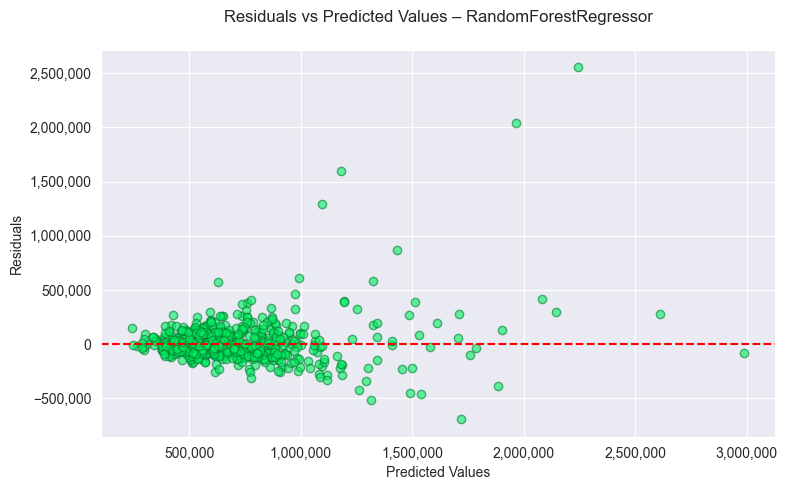

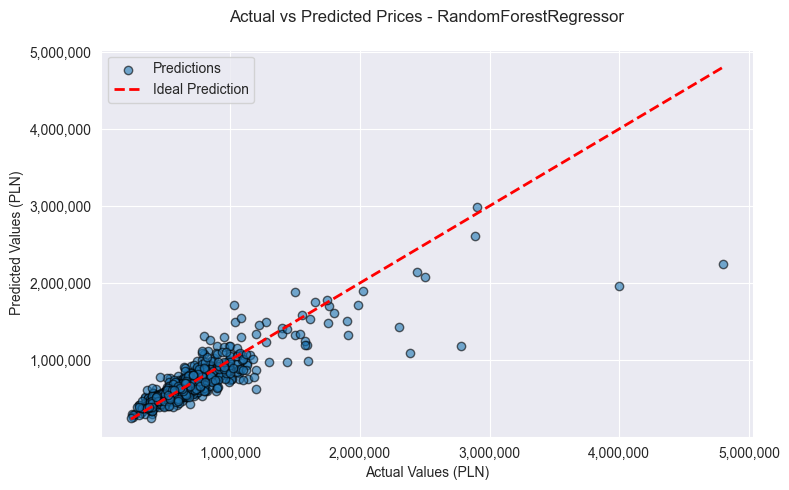

In [255]:
regression_plots(rf_pipeline, param_grid_rf)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 472, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 1199, in scor

Best params: {'regressor__learning_rate': 0.5, 'regressor__max_depth': 4, 'regressor__n_estimators': 100, 'regressor__subsample': 0.7}
Model: XGBRegressor
MAE: 84812.67103297634
MSE: 34848099020.808784
RMSE: 186676.45545383805
Cross-Validation RMSE: 164555.2030
R²: 0.7180695724515755



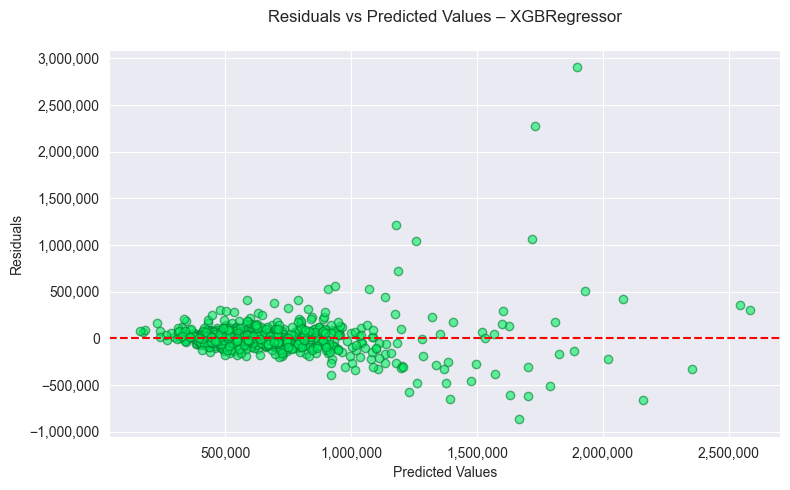

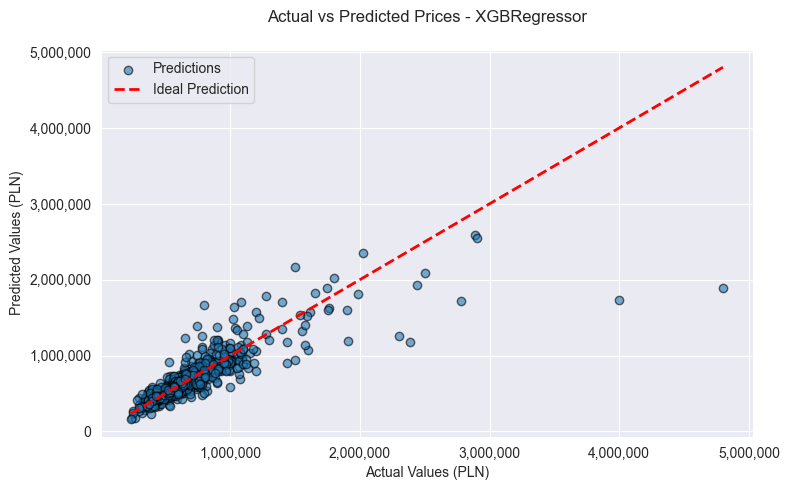

In [256]:
regression_plots(xgb_pipeline, param_grid_xgb)

Model: CatBoostRegressor
MAE: 72035.4083840803
MSE: 26098602791.713657
RMSE: 161550.6199050739
Cross-Validation RMSE: 147365.8500
R²: 0.7888553335695392



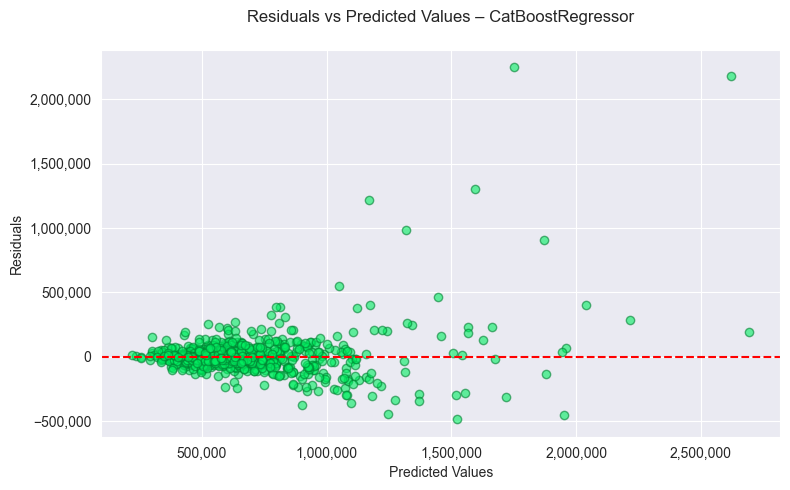

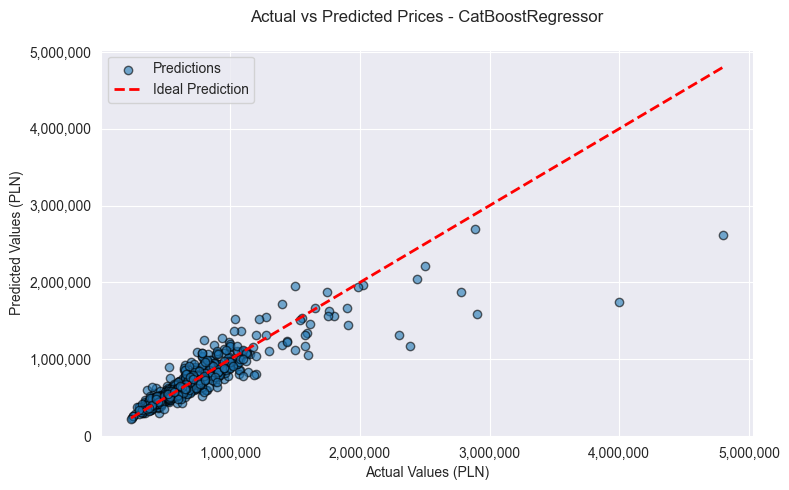

In [238]:
regression_plots(catboost_pipeline, param_grid_catboost)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warning

[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 3545, number of used features: 121
[LightGBM] [Info] Start training from score 677524.558824
Best params: {'regressor__depth': 3, 'regressor__learning_rate': 0.01, 'regressor__n_estimators': 500}
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 3545, number of used features: 121
[LightGBM] [Info] Start training from score 677524.558824
[LightGBM] [Warning] Unknown parameter: depth


/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Model: LGBMRegressor
MAE: 79279.35923587721
MSE: 28612792558.364098
RMSE: 169153.1630161378
Cross-Validation RMSE: 161826.5525
R²: 0.7685148669223809



/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


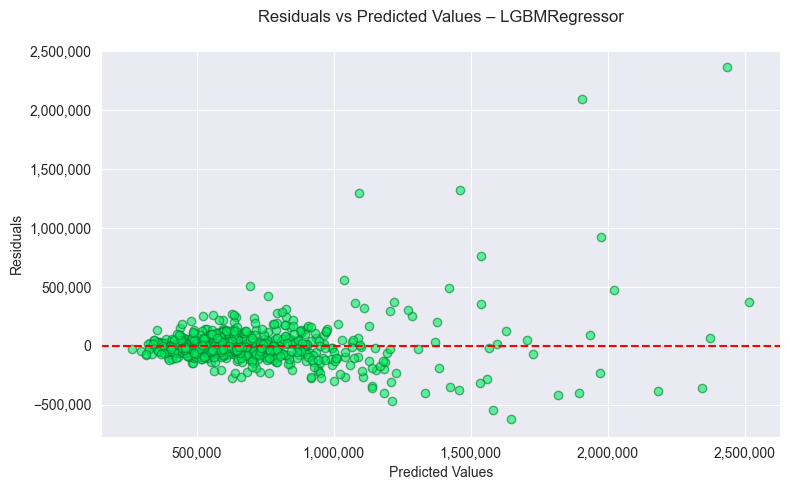

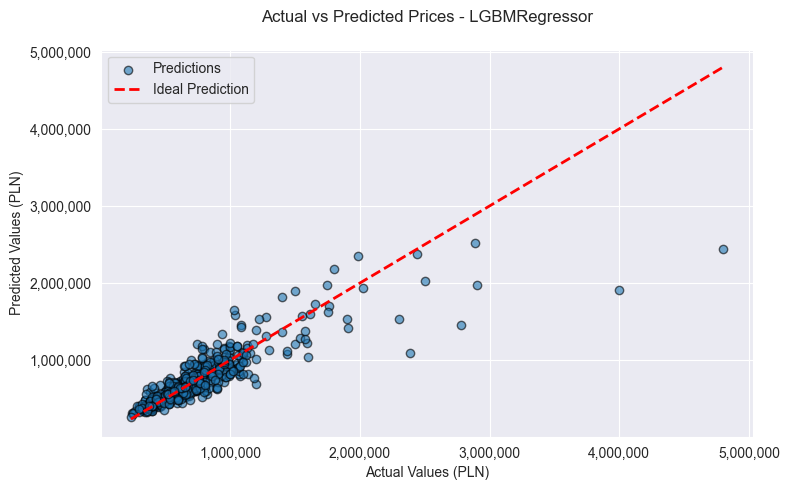

In [257]:
regression_plots(light_gbm_pipeline, param_grid_lightgbm)

In [322]:
calculate_metrics(svr_pipeline, param_grid_svr)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'regressor__C': 1.5, 'regressor__kernel': 'linear'}
Model: SVR
MAE: 190519.5668750116
MSE: 127188018464.84846
RMSE: 356634.29232877825
Cross-Validation RMSE: 348156.8195
R²: -0.028985035982012075



The best performing models were :
1. **CatBoost** -       Cross-Validation RMSE: 147365.8500, R²: 0.7888
2. **Random forest** -  Cross-Validation RMSE: 154909.3151, R²: 0.7634
3. **XGBoost** -        Cross-Validation RMSE: 165220.2991, R²: 0.7631
4. **Ligth GBM** -      Cross-Validation RMSE: 162131.7024, R²: 0.7811

But even so, these results are not perfect, and the model underestimates the most expensive premium housing, for this reason we will logarithmize the target ceche **price** to equalize the results and help the model better handle such values

Skewness: 3.887714
Kurtosis: 26.830896


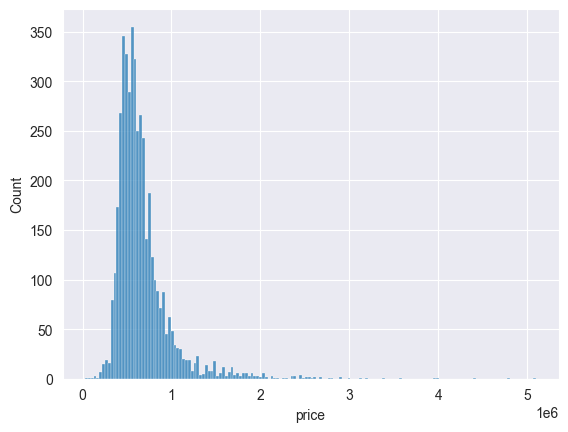

In [241]:
sns.histplot(y)
print("Skewness: %f" %y.skew())
print("Kurtosis: %f" %y.kurt())

Skewness: 0.716084
Kurtosis: 3.373667


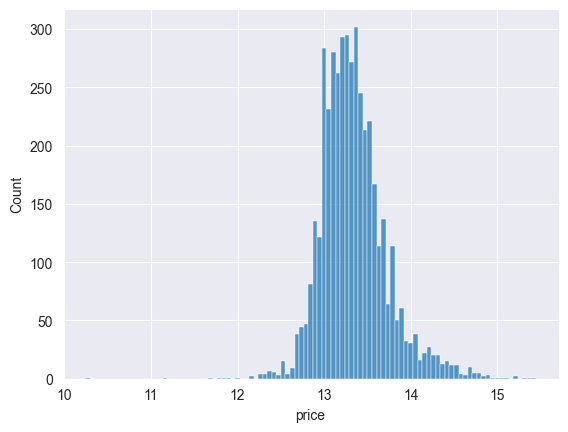

In [242]:
y_log = np.log1p(df['price'])
sns.histplot(y_log)
print("Skewness: %f" %y_log.skew())
print("Kurtosis: %f" %y_log.kurt())

After logarithmization **price** feature got a more normal distribution, this will help us when building the model and hopefully work better with outliers

### Models with logarizmied data

In [243]:
y_log = np.log1p(df['price'])
X_train, X_test, y_train_log, y_test_log = train_test_split(X , y_log ,test_size = 0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3545, 17), (887, 17), (3545,), (887,))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best params: {'regressor__depth': 7, 'regressor__iterations': 1000, 'regressor__l2_leaf_reg': 2.0, 'regressor__learning_rate': 0.1}
Model: CatBoostRegressor
MAE: 63978.82257422712
MSE: 22367049872.46586
RMSE: 149556.1763099935
Cross-Validation RMSE: 142749.3224
R²: 0.8190445932280045



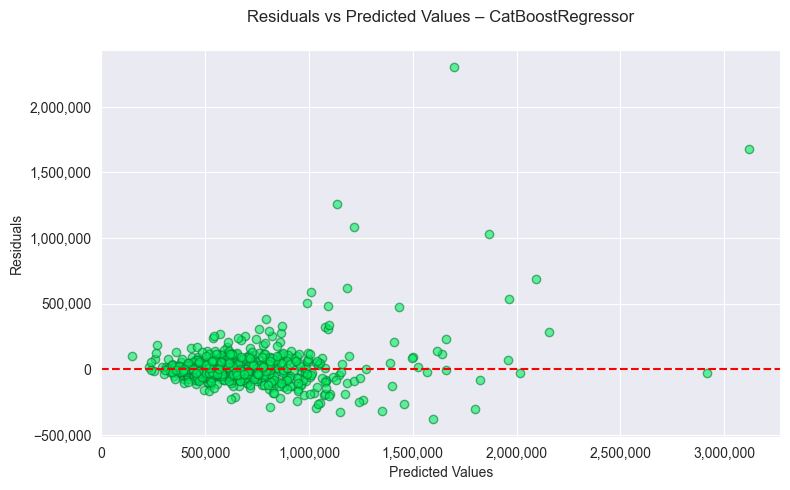

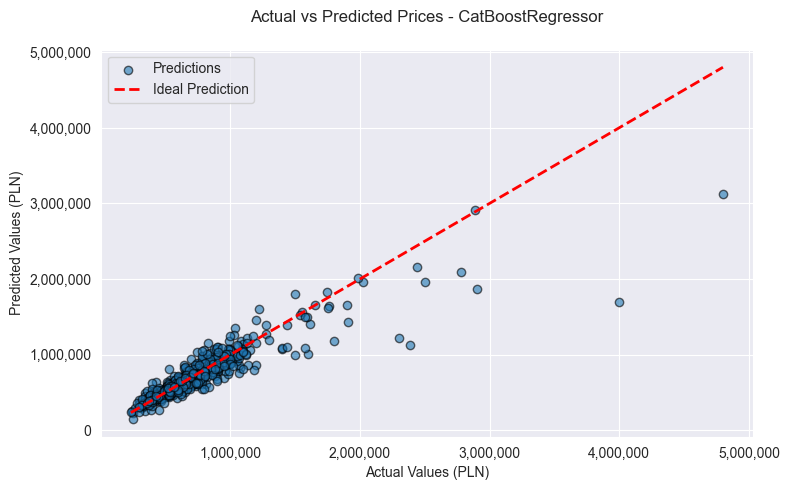

In [248]:
regression_plots(catboost_pipeline, param_grid_catboost, log=True,
                 X_train=X_train, X_test=X_test, y_train=y_train_log, y_test=y_test_log)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best params: {'regressor__bootstrap': True, 'regressor__max_depth': 8, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Model: RandomForestRegressor
MAE: 86524.87436727106
MSE: 32364312840.863205
RMSE: 179900.8416902578
Cross-Validation RMSE: 165635.8384
R²: 0.7381640659627648



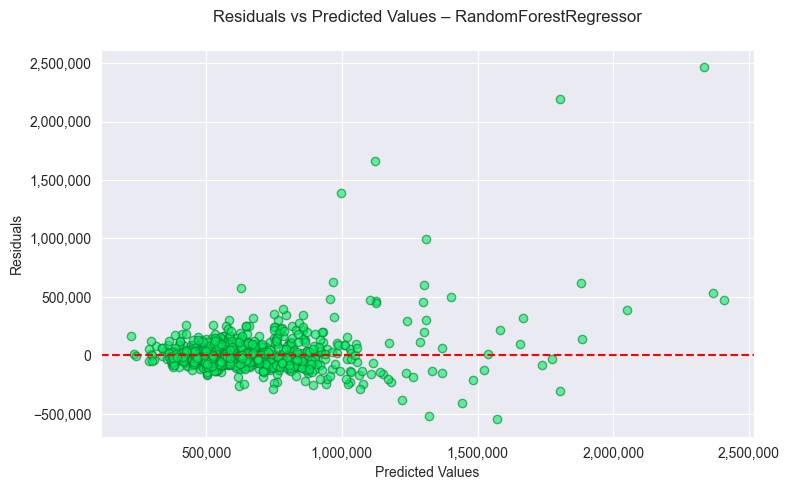

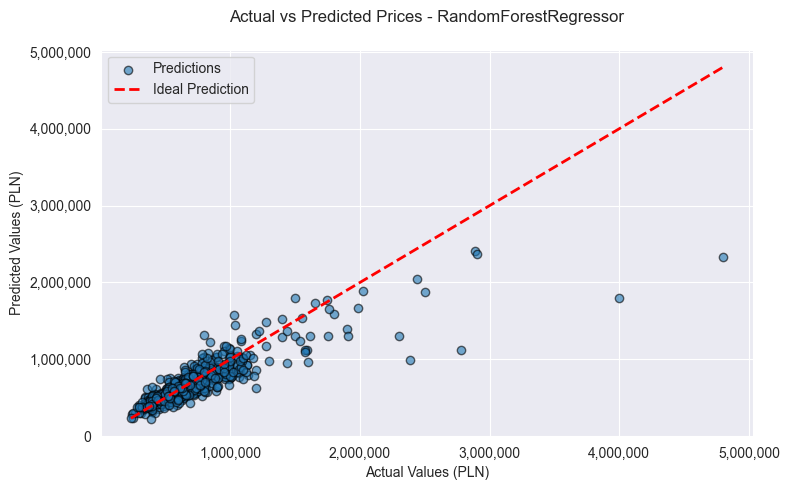

In [249]:
regression_plots(rf_pipeline,param_grid_rf, log=True,
                 X_train=X_train, X_test=X_test, y_train=y_train_log, y_test=y_test_log)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 472, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 1199, in scor

Best params: {'regressor__learning_rate': 0.5, 'regressor__max_depth': 4, 'regressor__n_estimators': 200, 'regressor__subsample': 1.0}
Model: XGBRegressor
MAE: 69102.01375140923
MSE: 23335911312.65646
RMSE: 152760.96135026272
Cross-Validation RMSE: 151887.7162
R²: 0.8112062454344846



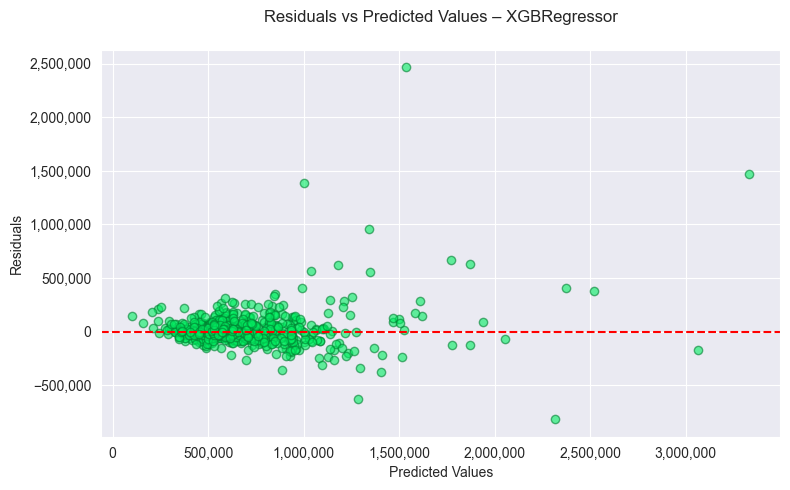

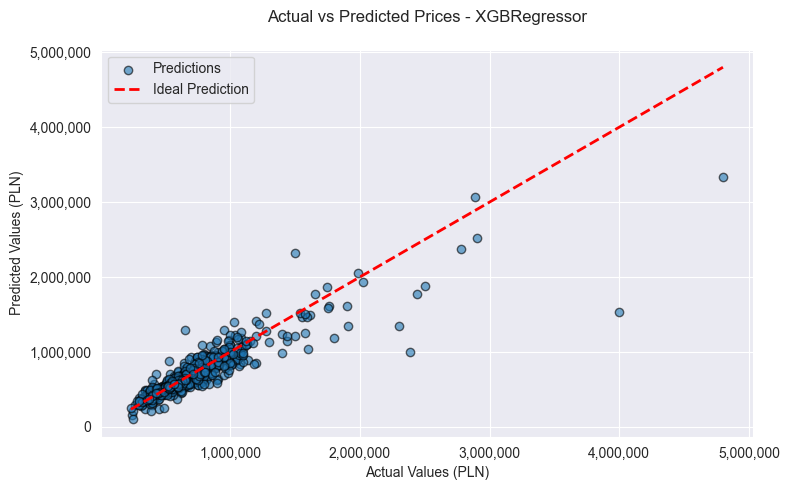

In [250]:
regression_plots(xgb_pipeline, param_grid_xgb, log=True,
                 X_train=X_train, X_test=X_test, y_train=y_train_log, y_test=y_test_log)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warning

[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 3545, number of used features: 121
[LightGBM] [Info] Start training from score 13.341695
Best params: {'regressor__depth': 3, 'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200}
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 3545, number of used features: 121
[LightGBM] [Info] Start training from score 13.341695
[LightGBM] [Warning] Unknown parameter: depth
Model: LGBMRegressor
MAE: 71077.08535133897
MSE: 27400744312.51136
RMSE: 165531.70183536253
Cross-Validation RMSE: 155154.4364
R²: 0.7783206609187345



/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/franekbiskup/Desktop/Portfolio/PolandPropertyScraper/project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warning

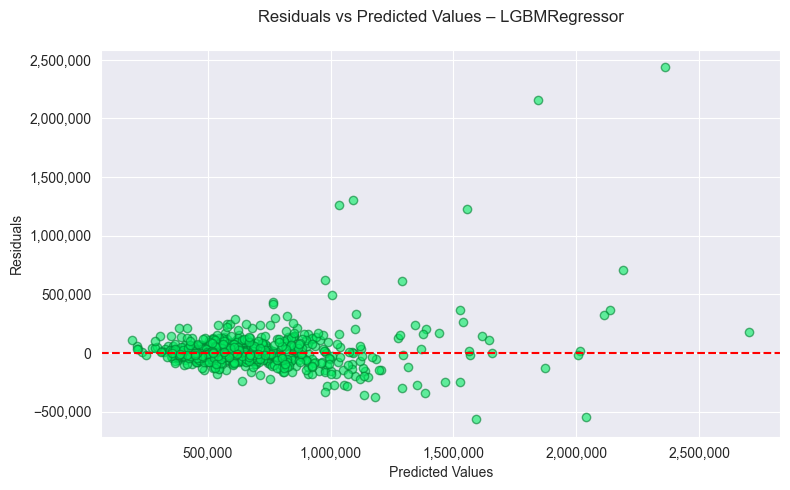

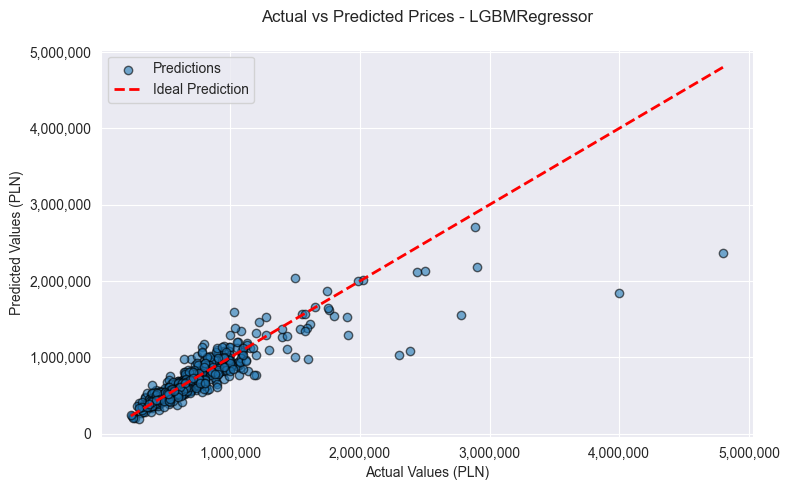

In [252]:
regression_plots(light_gbm_pipeline, param_grid_lightgbm, log=True,
                 X_train=X_train, X_test=X_test, y_train=y_train_log, y_test=y_test_log)

Logarithmizing the target value **price** , did not give much better results. Let's see how models improve with grid search and cross-validation 

We will check how the model will improve after cutting extreme values from the model, while this will not be used because, it does not make much sense for the model, which can also process premium properties that are simply more expensive than typical values. So the whole thing is done out of pure curiosity. 

In [317]:
from scipy.stats._mstats_basic import winsorize

def winsorization(df, target_feature):
    
    new_feature = f'{target_feature}_winsorized'
    df[new_feature] = winsorize(df[target_feature], limits=[0.01, 0.025]) # Winsorization of the column
    return df[[target_feature, new_feature]].describe().round(2)


winsorization(df, 'price')

price  price_winsorized
count     4432.00           4432.00
mean    676349.94         662868.41
std     344634.88         270339.79
min      28000.00         279000.00
25%     483813.00         483813.00
50%     598079.00         598079.00
75%     748270.00         748270.00
max    5100000.00        1620000.00

In [318]:
y_winsorized = df['price_winsorized']
X_train, X_test, y_train_winsorized, y_test_winsorized = train_test_split(X , y_winsorized ,test_size = 0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3545, 17), (887, 17), (3545,), (887,))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best params: {'regressor__depth': 6, 'regressor__iterations': 2000, 'regressor__l2_leaf_reg': 2.0, 'regressor__learning_rate': 0.1}
Model: CatBoostRegressor
MAE: 54346.746015372235
MSE: 7714226529.115672
RMSE: 87830.6696383198
Cross-Validation RMSE: 97801.3794
R²: 0.8832797896400435



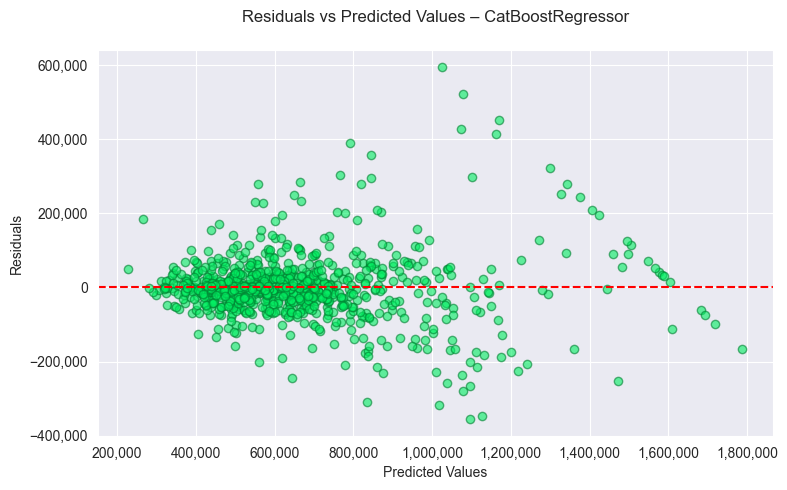

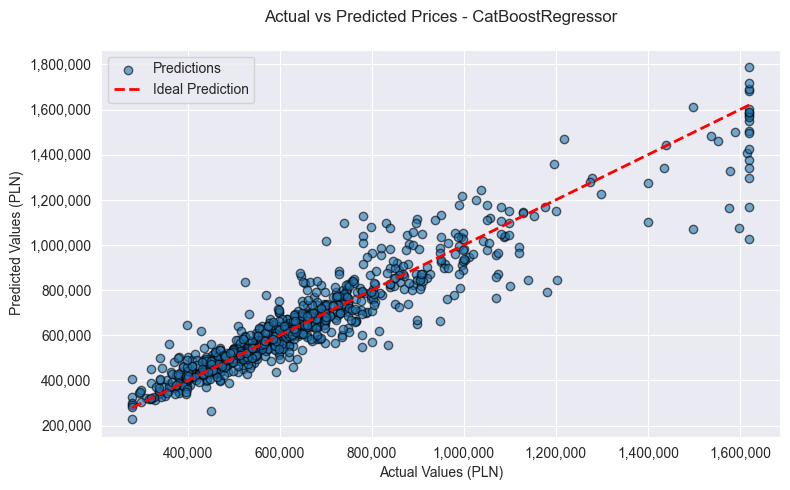

In [319]:
regression_plots(catboost_pipeline, param_grid_catboost, log = False,
                 X_train=X_train, X_test=X_test, y_train=y_train_winsorized, y_test=y_test_winsorized )

As we can see, the model has improved its metrics but we still won't use it because it doesn't solve the problem. 